# **DATA PREPROCESSING**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from numpy import float64
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


First we load the data, and remove the last row which contains the total sum of all of the ingredients and remove all duplicates in the data, which in total removed 866 rows. We then split the data into two parts, one containing all the features, and the other contains IDs and names of the foods.

In [2]:
path = 'ingredients.xlsx'

ingredients_initial = pd.read_excel(path, engine="openpyxl")
ingredients_initial.drop(ingredients_initial.tail(1).index, inplace=True)
ingredients_initial.drop_duplicates(inplace=True)

labels_initial = ingredients_initial.take([0, 1], axis=1)
ingredients_initial.drop(columns=["NDB_No", "Descrip"], inplace=True)

Let's see some basic information.

In [3]:
ingredients_initial.info()
ingredients_initial.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 9385 entries, 0 to 10248
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Energy_kcal       9381 non-null   float64
 1   Protein_g         9383 non-null   float64
 2   Saturated_fats_g  9380 non-null   float64
 3   Fat_g             9380 non-null   float64
 4   Carb_g            9026 non-null   float64
 5   Fiber_g           9026 non-null   float64
 6   Sugar_g           9383 non-null   float64
 7   Calcium_mg        9382 non-null   float64
 8   Iron_mg           9381 non-null   float64
 9   Magnesium_mg      9382 non-null   object 
 10  Phosphorus_mg     9383 non-null   float64
 11  Potassium_mg      9383 non-null   float64
 12  Sodium_mg         9383 non-null   float64
 13  Zinc_mg           9382 non-null   float64
 14  Copper_mcg        9383 non-null   float64
 15  Manganese_mg      9381 non-null   float64
 16  Selenium_mcg      9378 non-null   float64
 17 

Energy_kcal    Protein_g  Saturated_fats_g        Fat_g       Carb_g  \
count  9381.000000  9383.000000      9.380000e+03  9380.000000  9026.000000   
mean    220.853088    13.007680      4.860480e+12    11.313699    22.279259   
std     169.117866    72.053286      3.540225e+14    58.782743    59.355498   
min      -1.000000     0.000000     -1.000000e+00     0.000000     0.000000   
25%      86.000000     2.350000      1.360000e-01     0.820000     0.000000   
50%     183.000000     8.100000      1.320000e+00     4.800000     8.700000   
75%     330.776000    19.855000      4.007250e+00    13.252500    32.690000   
max     902.000000  4983.000000      3.171000e+16  4753.000000  4893.000000   

           Fiber_g      Sugar_g   Calcium_mg      Iron_mg  Phosphorus_mg  ...  \
count  9026.000000  9383.000000  9382.000000  9381.000000    9383.000000  ...   
mean      2.187098     7.816525    71.223848     2.796938     148.777344  ...   
std       4.689516    50.167249   196.765649     6.032798     197.060683  ...   
min       0.000000     0.000000    -1.000000     0.000000      -1.000000  ...   
25%       0.000000     0.000000     8.000000     0.460000      29.000000  ...   
50%       0.400000     0.550000    18.000000     1.300000     122.000000  ...   
75%       2.500000     6.350000    60.000000     2.610000     214.000000  ...   
max     127.000000  4446.000000  7364.000000   123.600000    9918.000000  ...   

        Thiamin_mg  Riboflavin_mg    Niacin_mg     VitB6_mg   Folate_mcg  \
count  9384.000000    9380.000000  9381.000000  9381.000000  9384.000000   
mean      0.618801       0.449855     3.191021     1.805300    35.324760   
std       3.685100       4.136072     4.600813    15.101987   158.492891   
min      -1.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.030000       0.040000     0.300000     0.038000     0.000000   
50%       0.078000       0.144500     1.800000     0.127000     6.000000   
75%       0.245000       0.260000     4.829000     0.360000    19.000000   
max     116.800000     260.800000   127.500000   264.000000  2875.000000   

        VitB12_mcg      VitA_mcg     VitD2_mcg  Unnamed: 29  Unnamed: 30  
count  9380.000000   9376.000000   9382.000000   354.000000   354.000000  
mean      1.174743     85.290482      5.134914     0.611949     0.318424  
std       5.856678    710.147959    239.580789     2.082292     1.353886  
min       0.000000      0.000000      0.000000     0.000000     0.000000  
25%       0.000000      0.000000      0.000000     0.000000     0.000000  
50%       0.020000      1.000000      0.000000     0.125000     0.000000  
75%       1.010000     19.000000      0.001010     0.467500     0.000168  
max     316.000000  30000.000000  19872.000000    22.890000    16.100000  

[8 rows x 27 columns]

These columns are incorrect, we need to drop them.

In [4]:
ingredients_initial = ingredients_initial.drop(columns=["Unnamed: 29", "Unnamed: 30"])

We need to convert non-numeric values to numeric. If such conversion is not possible, we use NaN as the value.

In [5]:
# Value 'X'
ingredients_initial['Magnesium_mg'] = pd.to_numeric(ingredients_initial['Magnesium_mg'], errors='coerce')
# Values like '0.23 0.34'
ingredients_initial['VitE_mg'] = pd.to_numeric(ingredients_initial['VitE_mg'], errors='coerce')

ingredients_initial['VitE_mg'] = ingredients_initial['VitE_mg'].astype(float64)
ingredients_initial['Magnesium_mg'] = ingredients_initial['Magnesium_mg'].astype(float64)

Then we fill in the missing portions of our data and NaN values using the KNNImputer. This way we do not need to drop incomplete rows.

In [6]:
imputer = KNNImputer()
data = imputer.fit_transform(ingredients_initial)
ingredients_initial = pd.DataFrame(data, columns=ingredients_initial.columns, index=ingredients_initial.index)

In [7]:
ingredients_initial.info()
ingredients_initial.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 9385 entries, 0 to 10248
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Energy_kcal       9385 non-null   float64
 1   Protein_g         9385 non-null   float64
 2   Saturated_fats_g  9385 non-null   float64
 3   Fat_g             9385 non-null   float64
 4   Carb_g            9385 non-null   float64
 5   Fiber_g           9385 non-null   float64
 6   Sugar_g           9385 non-null   float64
 7   Calcium_mg        9385 non-null   float64
 8   Iron_mg           9385 non-null   float64
 9   Magnesium_mg      9385 non-null   float64
 10  Phosphorus_mg     9385 non-null   float64
 11  Potassium_mg      9385 non-null   float64
 12  Sodium_mg         9385 non-null   float64
 13  Zinc_mg           9385 non-null   float64
 14  Copper_mcg        9385 non-null   float64
 15  Manganese_mg      9385 non-null   float64
 16  Selenium_mcg      9385 non-null   float64
 17 

Energy_kcal    Protein_g  Saturated_fats_g        Fat_g       Carb_g  \
count  9385.000000  9385.000000      9.385000e+03  9385.000000  9385.000000   
mean    220.933913    13.015485      9.715781e+12    11.312971    22.477156   
std     169.230634    72.048847      4.116972e+14    58.767314    58.402695   
min      -1.000000     0.000000     -1.000000e+00     0.000000     0.000000   
25%      86.000000     2.350000      1.360000e-01     0.820000     0.050000   
50%     183.000000     8.100000      1.322000e+00     4.800000     9.400000   
75%     331.000000    19.870000      4.023000e+00    13.260000    32.920000   
max     902.000000  4983.000000      3.171000e+16  4753.000000  4893.000000   

           Fiber_g      Sugar_g   Calcium_mg      Iron_mg  Magnesium_mg  ...  \
count  9385.000000  9385.000000  9385.000000  9385.000000   9385.000000  ...   
mean      2.155496     7.815920    71.234349     2.796861    366.434880  ...   
std       4.617775    50.161924   196.746511     6.031771   3884.407931  ...   
min       0.000000     0.000000    -1.000000     0.000000      0.000000  ...   
25%       0.000000     0.000000     8.000000     0.460000     10.000000  ...   
50%       0.500000     0.560000    18.000000     1.300000     21.000000  ...   
75%       2.500000     6.350000    60.000000     2.610000     31.000000  ...   
max     127.000000  4446.000000  7364.000000   123.600000  46022.000000  ...   

           VitC_mg   Thiamin_mg  Riboflavin_mg    Niacin_mg     VitB6_mg  \
count  9385.000000  9385.000000    9385.000000  9385.000000  9385.000000   
mean      8.443374     0.618752       0.449693     3.190303     1.804575   
std      63.893376     3.684907       4.134977     4.600053    15.098809   
min      -1.000000    -1.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.030000       0.040000     0.300000     0.038000   
50%       0.000000     0.078000       0.145000     1.800000     0.127000   
75%       2.400000     0.245000       0.260000     4.828000     0.360000   
max    2732.000000   116.800000     260.800000   127.500000   264.000000   

        Folate_mcg   VitB12_mcg      VitA_mcg       VitE_mg     VitD2_mcg  
count  9385.000000  9385.000000   9385.000000   9385.000000   9385.000000  
mean     35.320996     1.174557     85.256831   1664.739757      5.134296  
std     158.484866     5.855138    709.817219   8569.672031    239.542505  
min       0.000000     0.000000      0.000000      0.000000      0.000000  
25%       0.000000     0.000000      0.000000      0.000000      0.000000  
50%       6.000000     0.020000      1.000000      0.120000      0.000000  
75%      19.000000     1.010000     19.000000      0.490000      0.001020  
max    2875.000000   316.000000  30000.000000  46012.000000  19872.000000  

[8 rows x 27 columns]

The following functions are used for visualizing the data in various ways.

In [8]:
def draw_boxplots(df):
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 20))

    axes = axes.flatten()

    n = len(df.columns)
    for i, column in enumerate(df.columns):
        sns.boxplot(data=df.iloc[:, i], ax=axes[i])
        axes[i].set_title(column)

    for i in range(n, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


def draw_correlation_matrix(df):
    corr_matrix = df.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()


def draw_distribution_functions(df):
    num_features = len(df.columns)
    num_rows = (num_features + 4) // 5

    plt.figure(figsize=(15, num_rows * 3))

    for i, feature in enumerate(df.columns):
        plt.subplot(num_rows, 5, i+1)
        sns.kdeplot(df[feature], fill=True, color='blue', alpha=0.5)
        plt.title(feature)
        plt.tight_layout()

    plt.show()

Let's see some graphs.

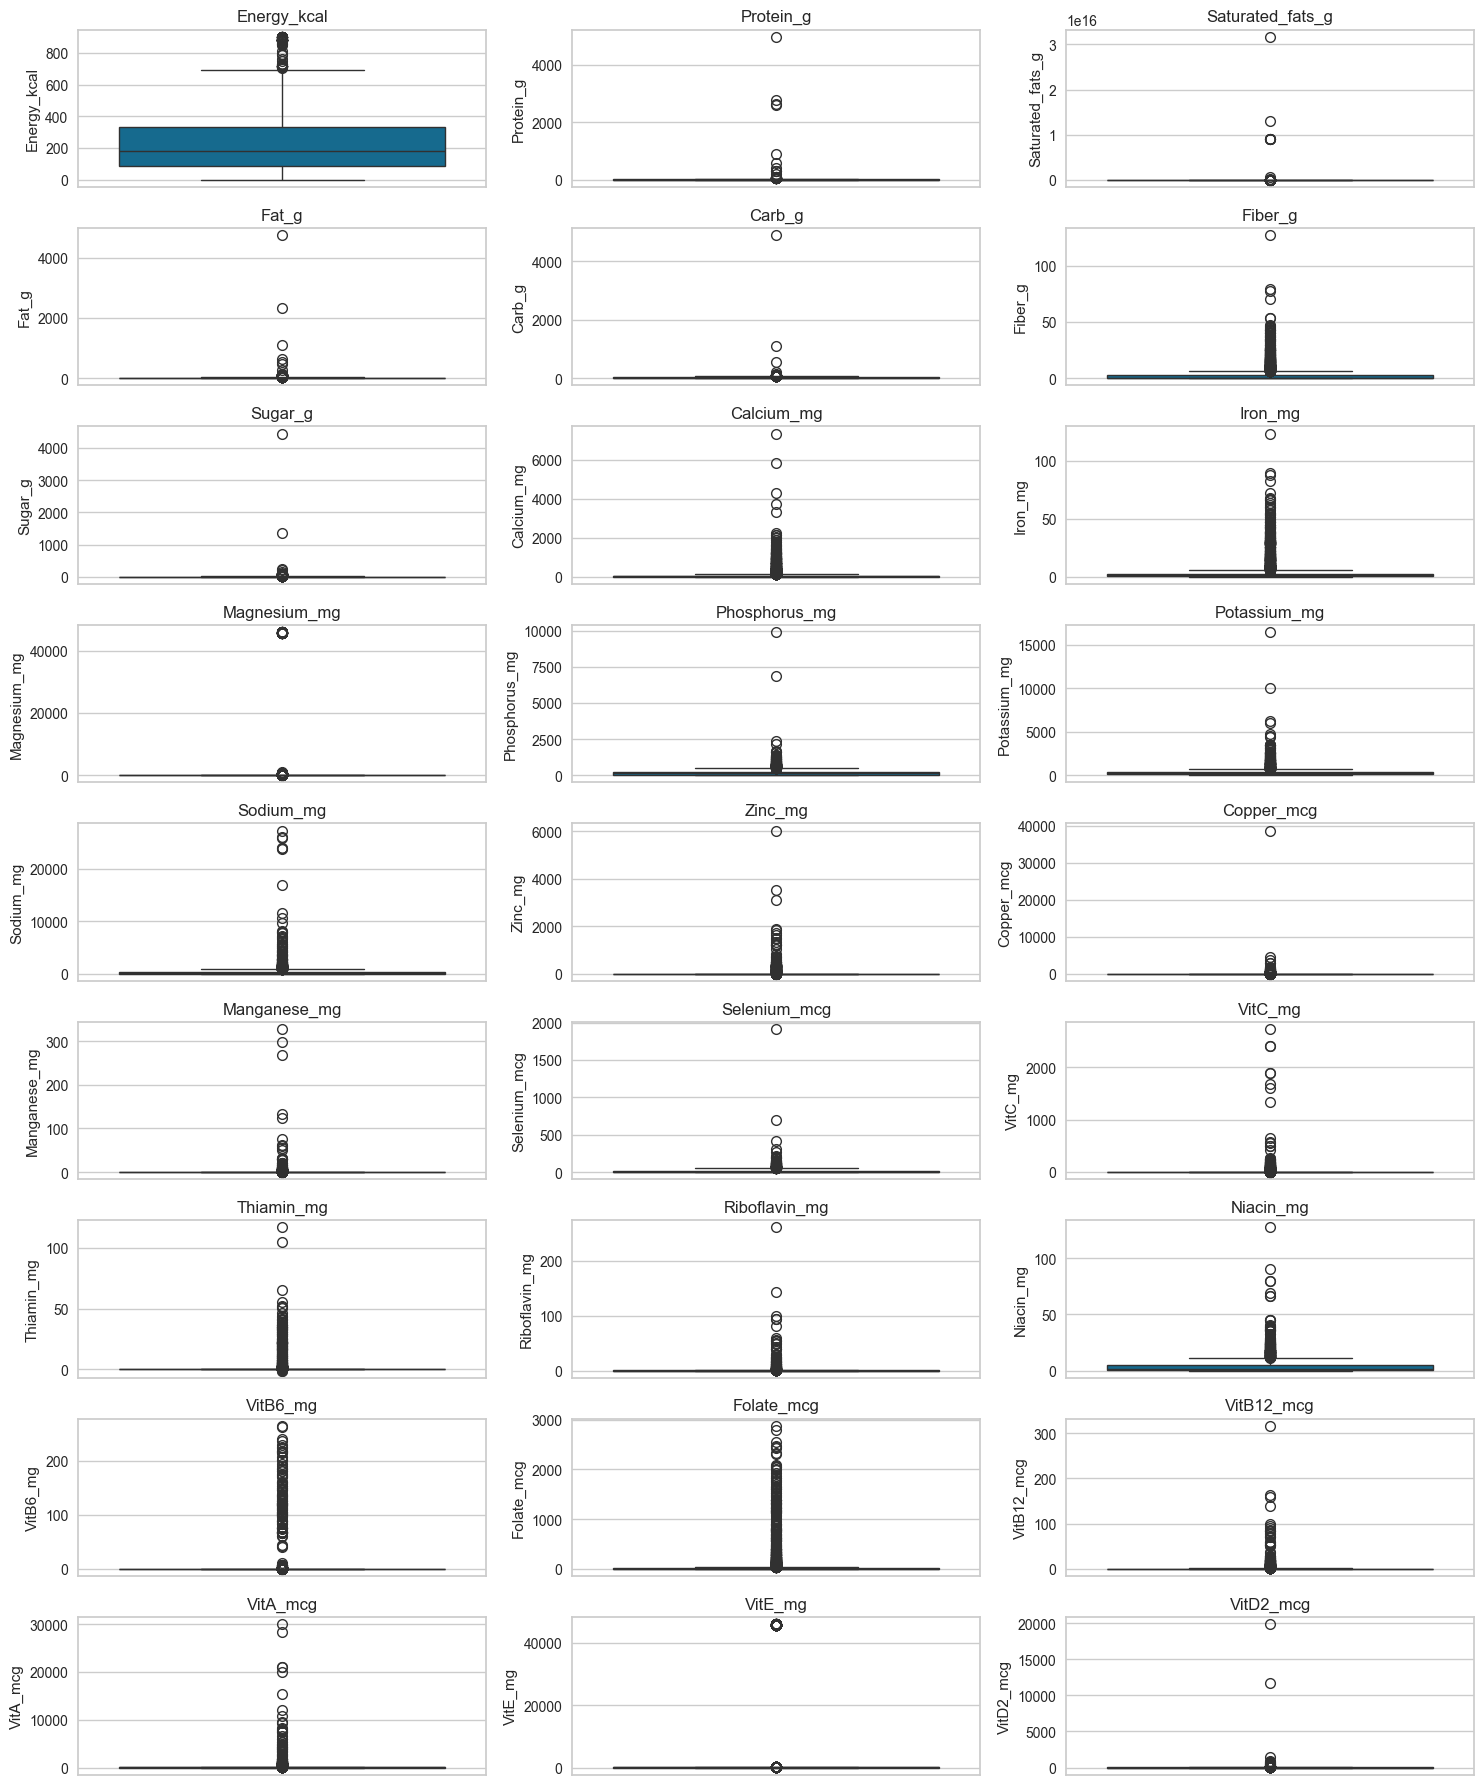

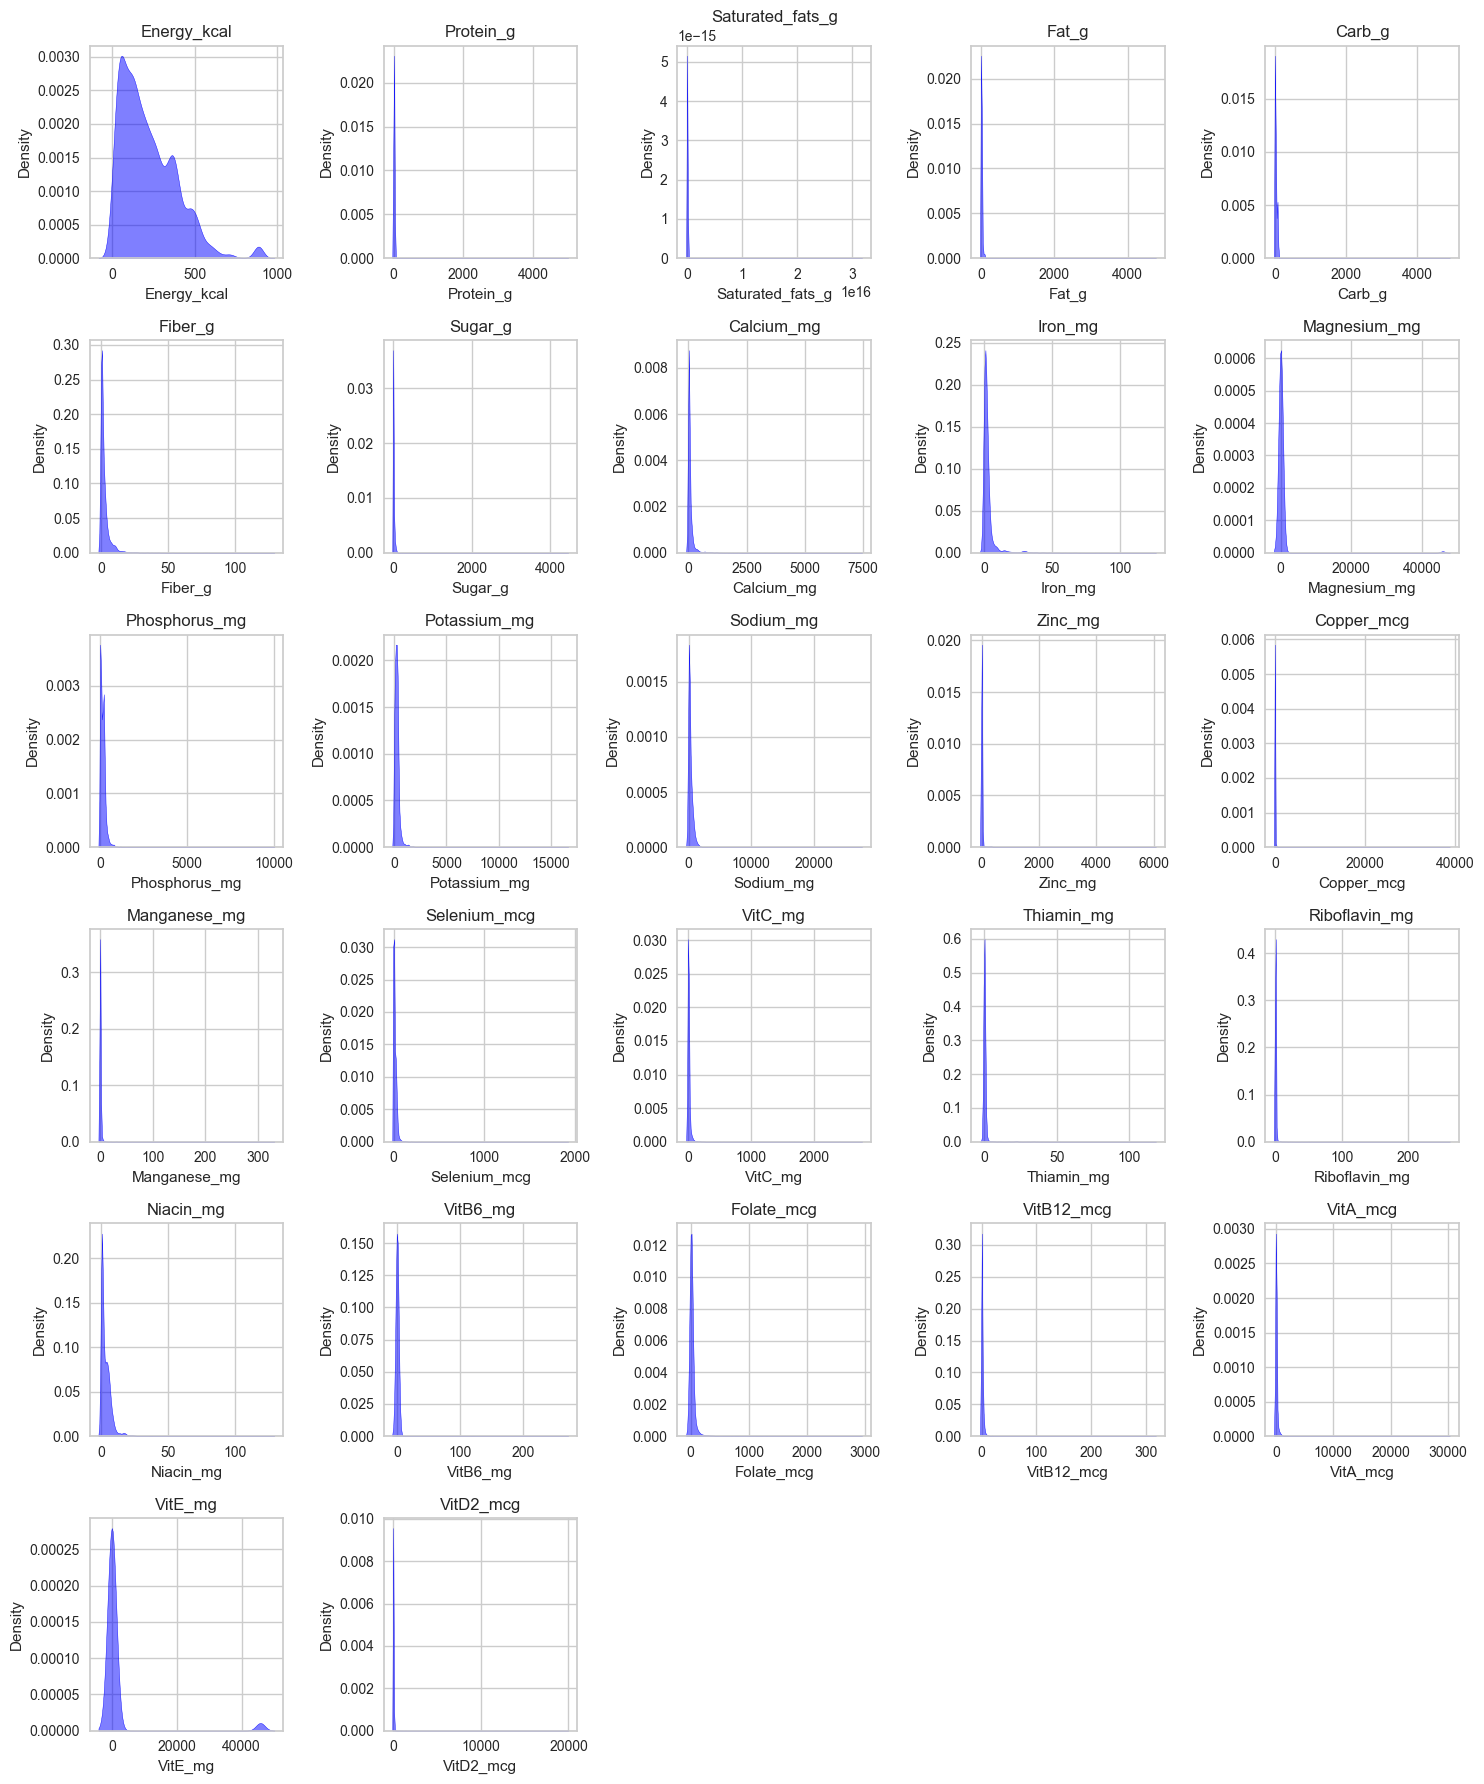

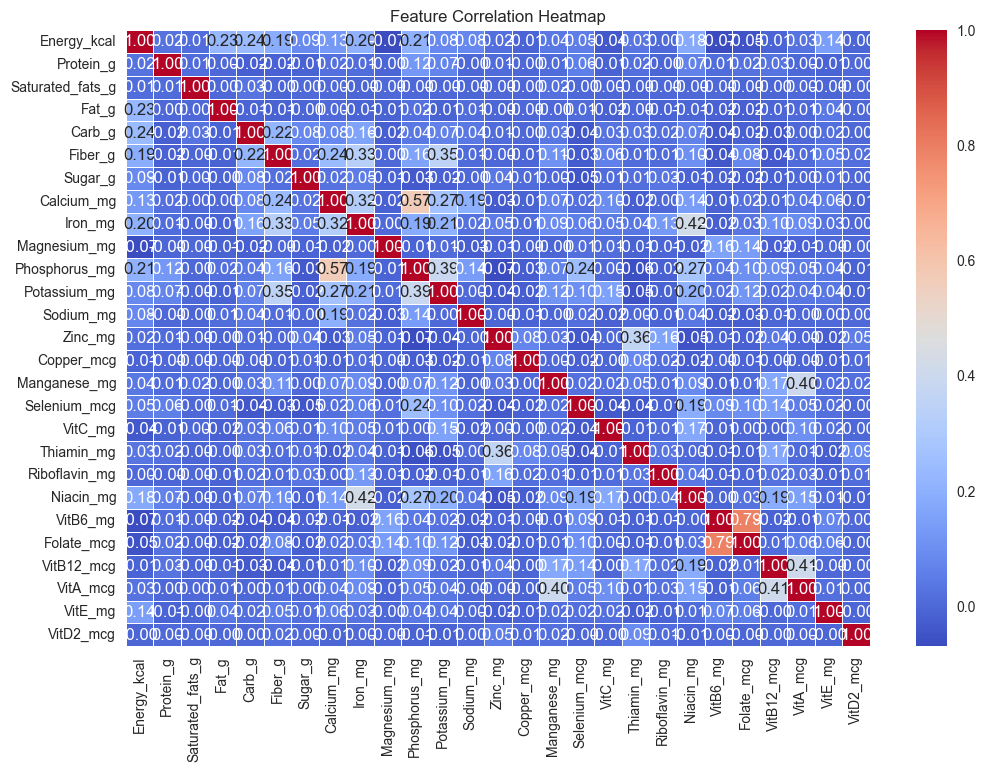

In [9]:
draw_boxplots(ingredients_initial)
draw_distribution_functions(ingredients_initial)
draw_correlation_matrix(ingredients_initial)

Then we convert all the numbers to the same unit - grams.

In [10]:
def convert_to_grams(df):
    df_copy = df.copy()

    for column in df_copy.columns:
        column_split = column.rsplit("_", 1)
        name = column_split[0]
        unit = column_split[-1]

        if unit == 'mg':
            df_copy[column] = df_copy[column] / 1000
            df_copy.rename(columns={column : name + "_g"}, inplace=True)
        elif unit == 'mcg':
            df_copy[column] = df_copy[column] / 1000000
            df_copy.rename(columns={column : name + "_g"}, inplace=True)

    return df_copy


ingredients_initial = convert_to_grams(ingredients_initial)

In [11]:
ingredients_initial = pd.concat([labels_initial, ingredients_initial], axis=1)

As the values are per 100g of food, any values outside of the interval [0, 100] are invalid.

In [12]:
for column in ingredients_initial.columns[3:]:
  ingredients_initial = ingredients_initial[ingredients_initial[column] <= 100]

for column in ingredients_initial.columns[2:]:
  ingredients_initial = ingredients_initial[ingredients_initial[column] >= 0]

As saturated fats are a type of fat and sugar, fiber are types of carbs, their values should not be greater than the values of fats and carbs, respectively.

In [13]:
# This nukes 286, not great not terrible
ingredients_initial = ingredients_initial[ingredients_initial["Saturated_fats_g"] <= ingredients_initial["Fat_g"]]
ingredients_initial = ingredients_initial[ingredients_initial["Sugar_g"] <= ingredients_initial["Carb_g"]]
ingredients_initial = ingredients_initial[ingredients_initial["Fiber_g"] <= ingredients_initial["Carb_g"]]

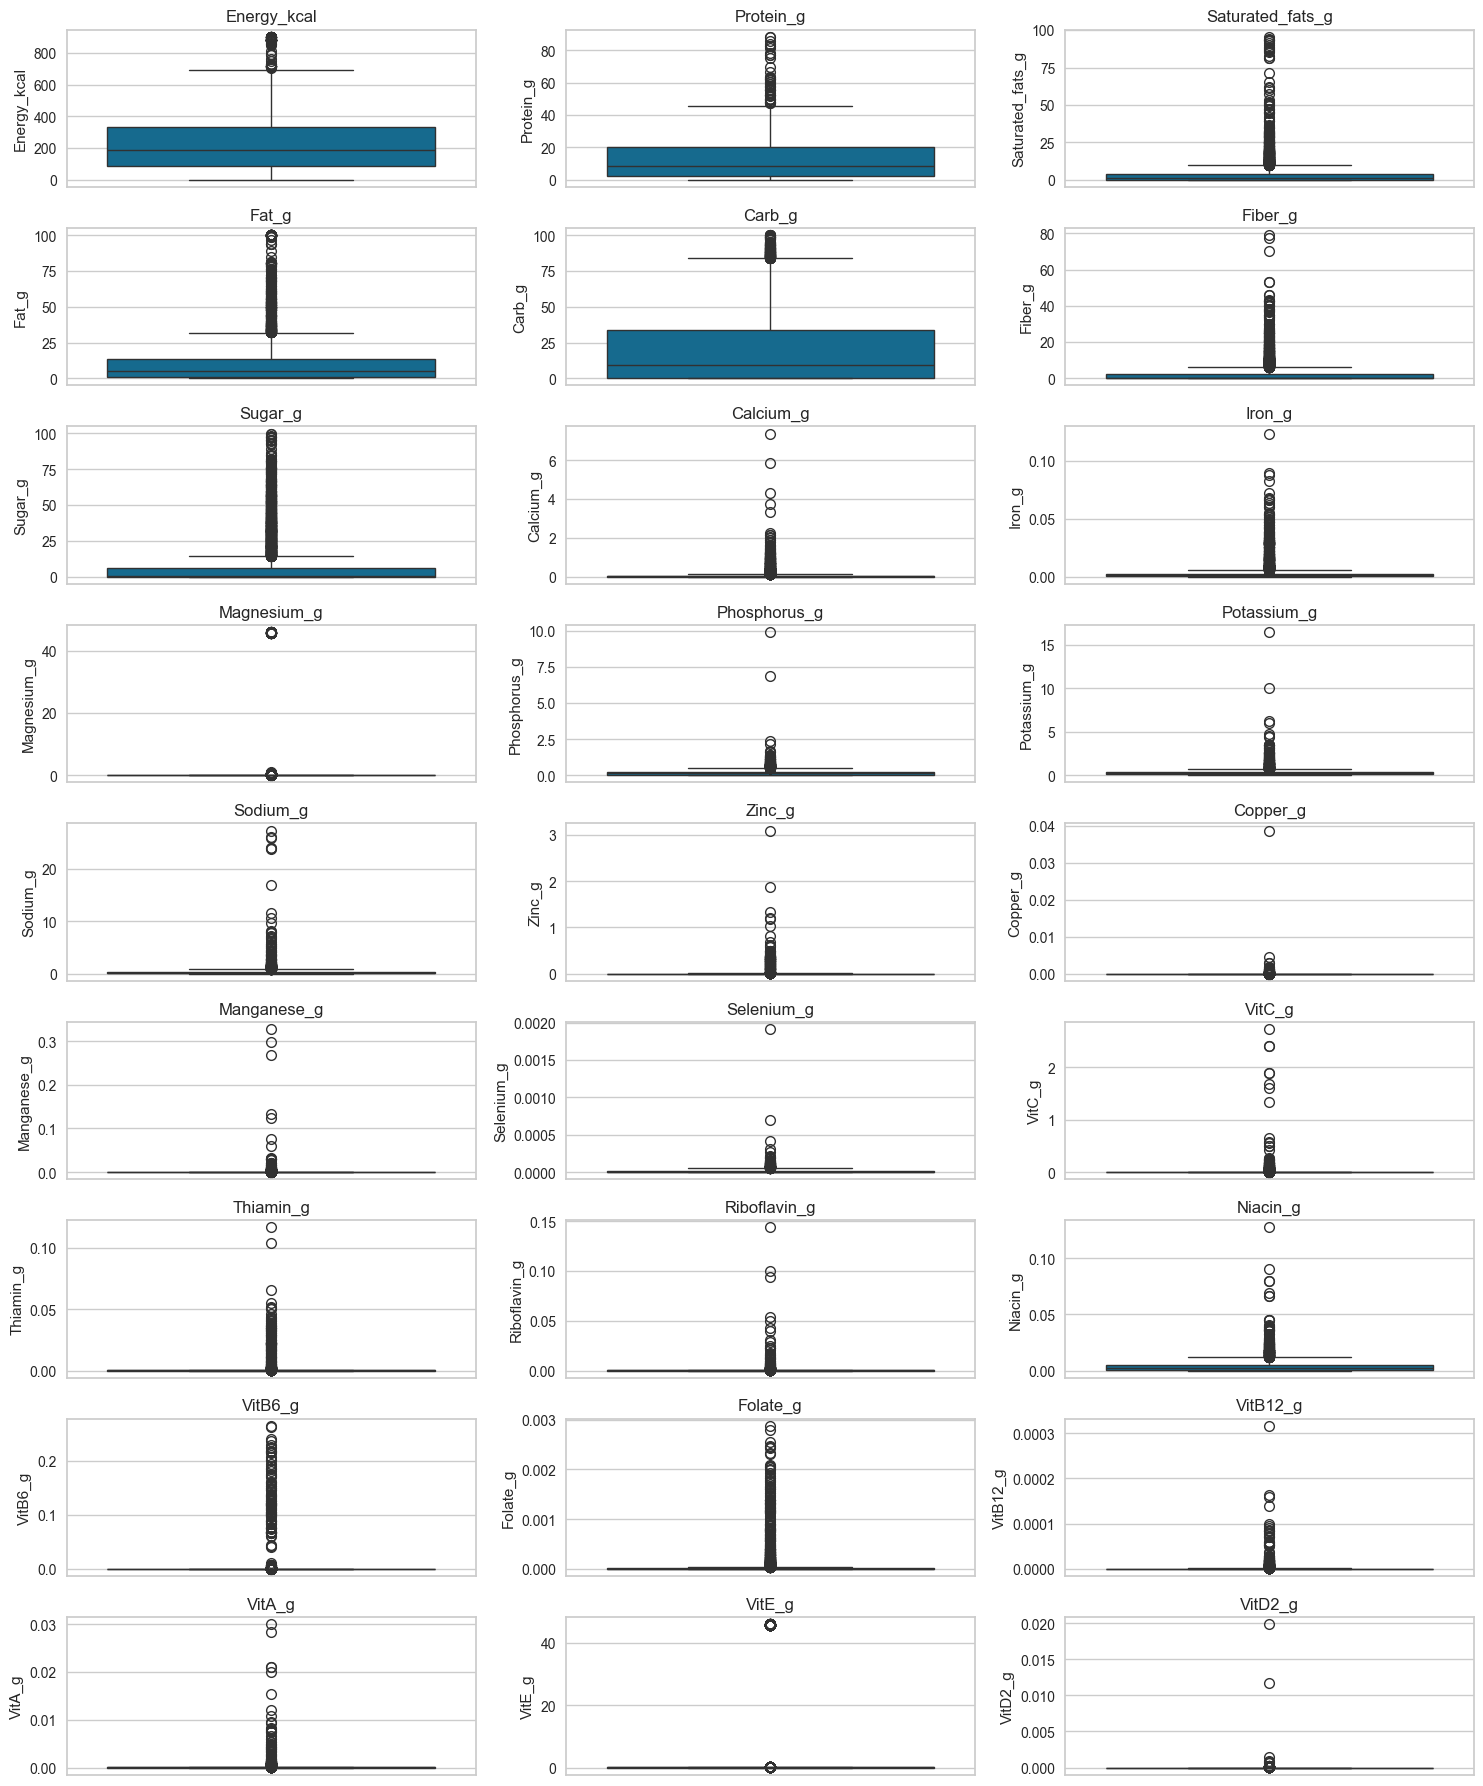

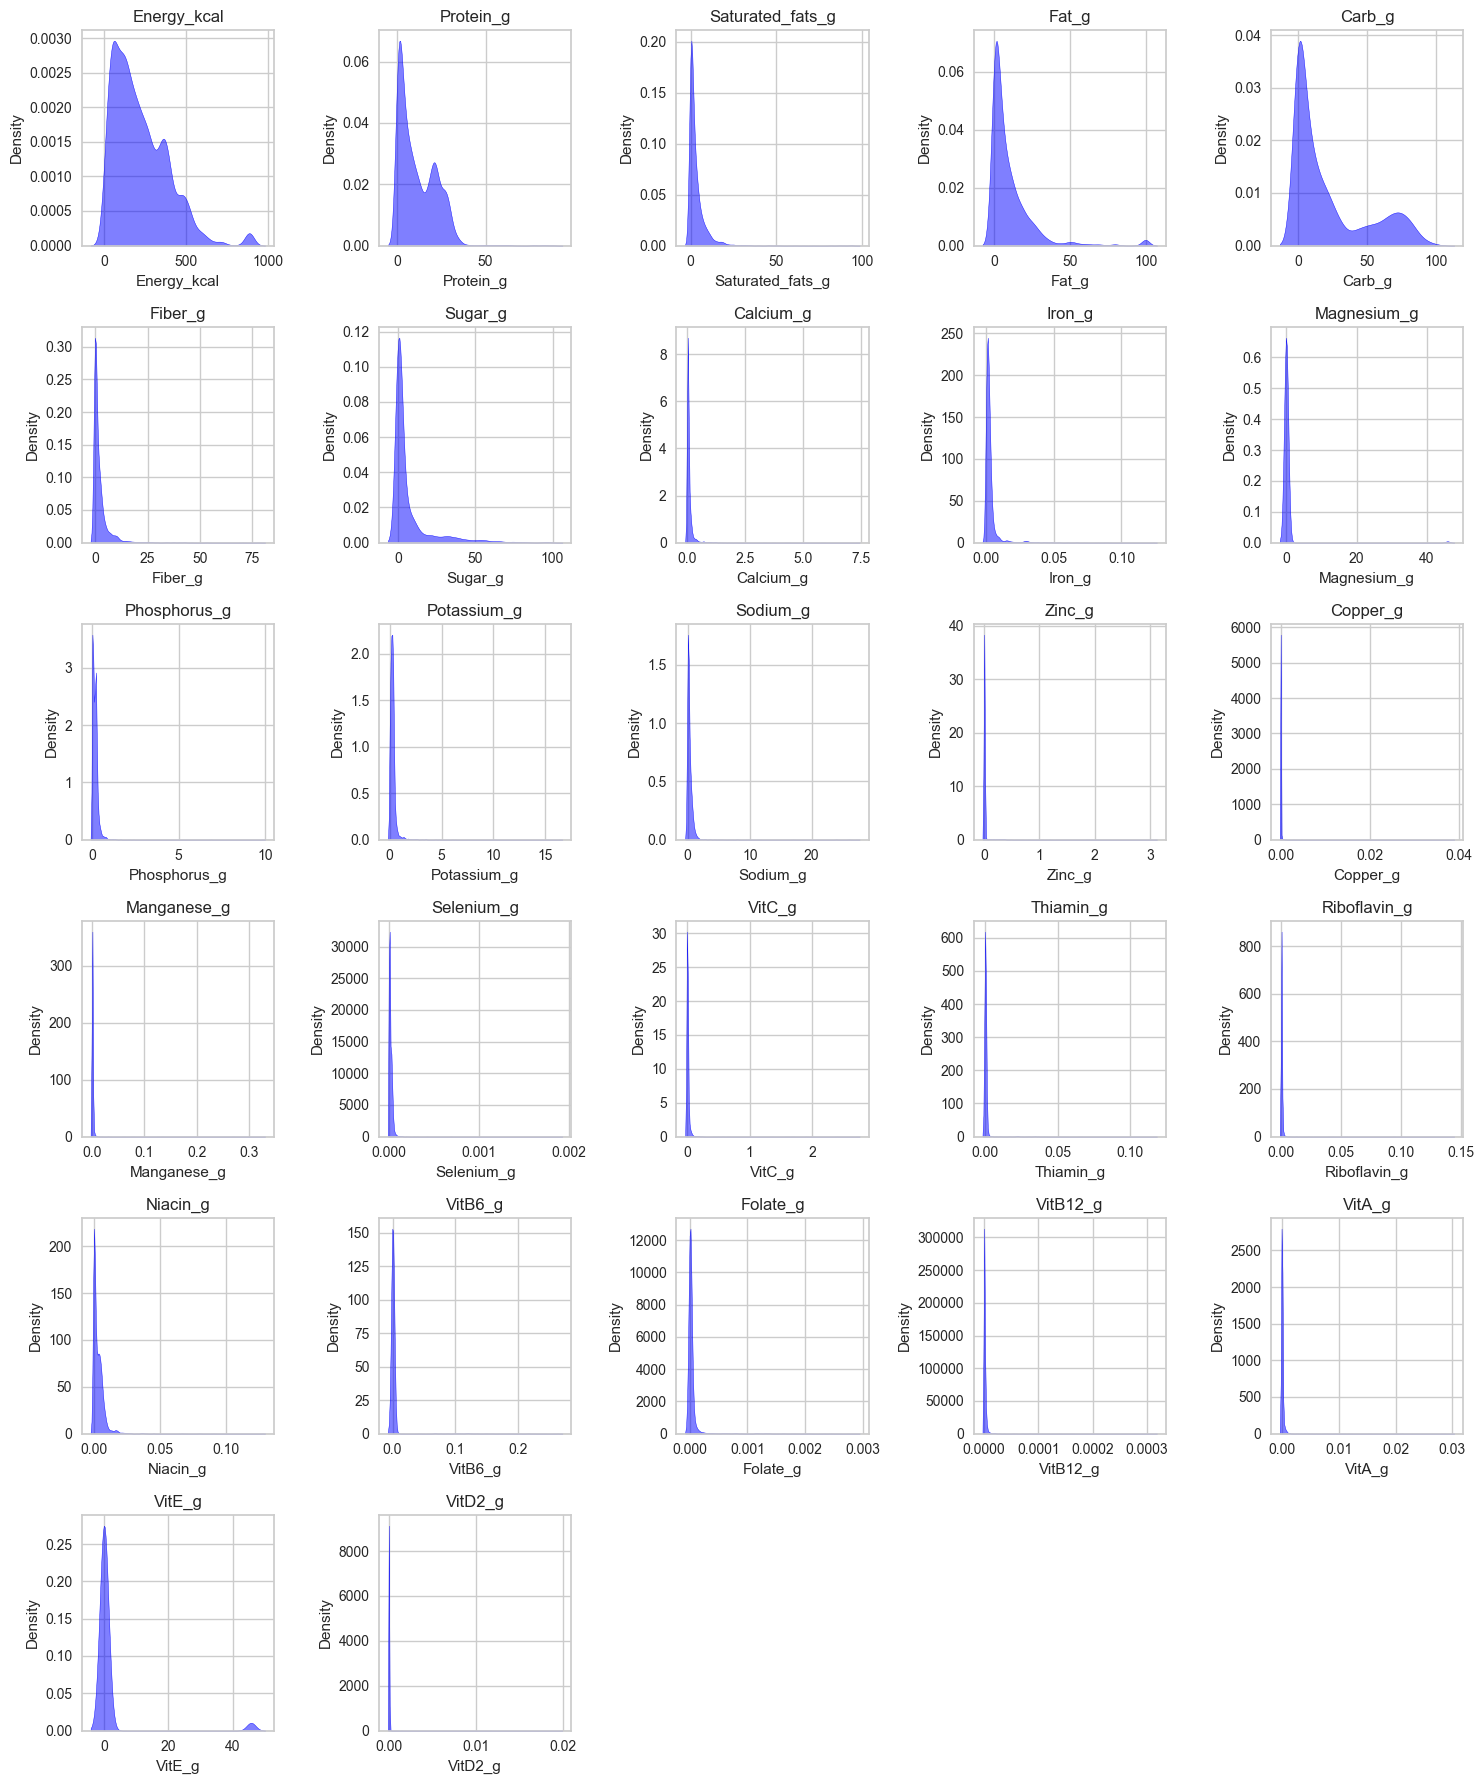

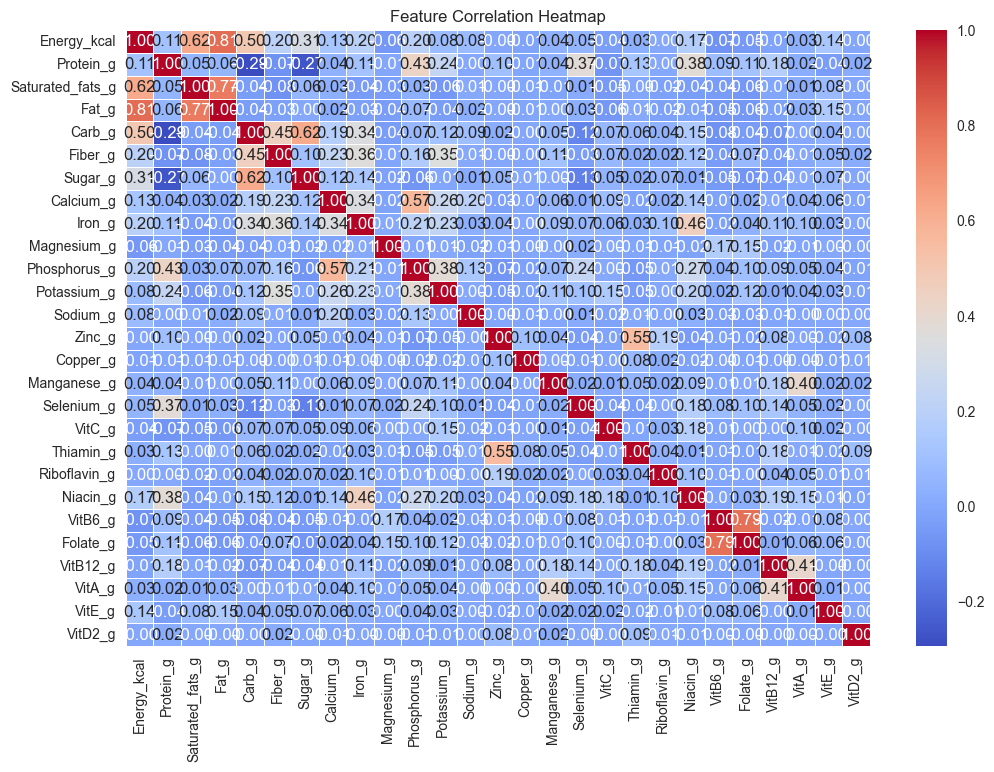

In [14]:
draw_boxplots(ingredients_initial.drop(columns=["NDB_No", "Descrip"]))
draw_distribution_functions(ingredients_initial.drop(columns=["NDB_No", "Descrip"]))
draw_correlation_matrix(ingredients_initial.drop(columns=["NDB_No", "Descrip"]))

Final part of the preprocessing - scaling. We tried both MinMaxScaler and StandardScaler.

In [15]:
ingredients_names = ingredients_initial.take([0, 1], axis=1)
ingredients = ingredients_initial.drop(columns=["NDB_No", "Descrip", "Energy_kcal"])
ingredients_standard = pd.DataFrame(StandardScaler().fit_transform(ingredients), columns=ingredients.columns, index=ingredients.index)
ingredients_minmax = pd.DataFrame(MinMaxScaler().fit_transform(ingredients), columns=ingredients.columns, index=ingredients.index)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

# **CLUSTERING**

In [16]:
def show_silhouette_plot(labels, silhouettes, silhouette_average):
    fig, ax = plt.subplots(figsize=(10, 6))

    y_lower = 10
    n_clusters = len(np.unique(labels))

    for i in range(n_clusters):
        # Get silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = silhouettes[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Add space between clusters

    # Average line
    ax.axvline(x=silhouette_average, color="red", linestyle="--")
    ax.set_title("Silhouette Plot for Agglomerative Clustering")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_yticks([])  # Hide y-axis tick marks
    plt.show()

def get_dbscan_coverage(labels):
    total = len(labels)
    non_noise = len(labels[labels != -1])
    return non_noise / total * 100

## **KMEANS CLUSTERING**

In [17]:
def print_scaler_header(scaler):
    char_count = 96

    print("*" * char_count)
    if scaler == None:
        print(" No Scaler ".center(char_count, "*"))
    elif scaler.__class__.__name__ == "MinMaxScaler":
        print(" Min Max Scaler ".center(char_count, "*"))
    else:
        print(" Standard Scaler ".center(char_count, "*"))
    print("*" * char_count)


def cluster_with_KMeans(dataset):
    for scaler in [None, MinMaxScaler(), StandardScaler()]:
        print_scaler_header(scaler)

        if scaler is None:
            scaled_data = dataset
        else:
            scaled_data = scaler.fit_transform(dataset)

        for metric in ["distortion", "silhouette", "calinski_harabasz"]:
            elbow_visualizer = KElbowVisualizer(KMeans(random_state=42), metric=metric, k=20)
            elbow_visualizer.fit(scaled_data)
            elbow_visualizer.show()

            silhouette_visualizer = SilhouetteVisualizer(KMeans(elbow_visualizer.elbow_value_, random_state=42), colors="yellowbrick")
            silhouette_visualizer.fit(scaled_data)
            silhouette_visualizer.show()

************************************************************************************************
****************************************** No Scaler *******************************************
************************************************************************************************


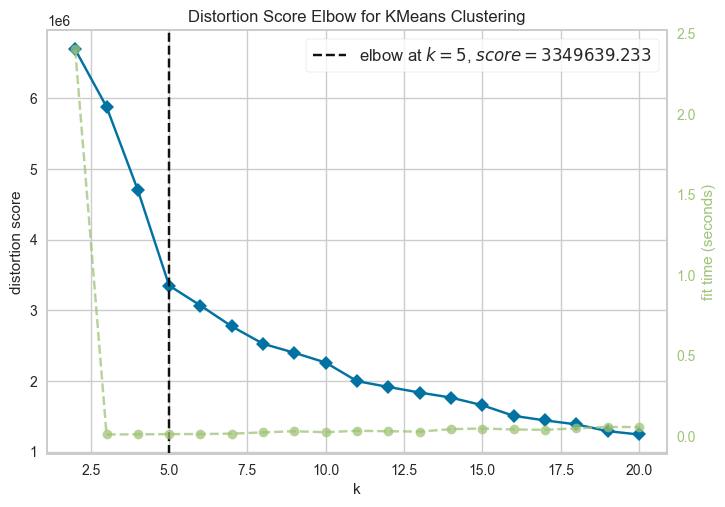

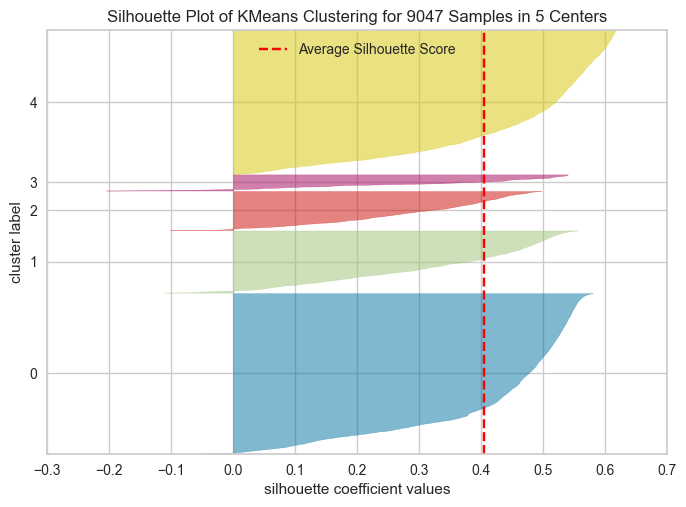

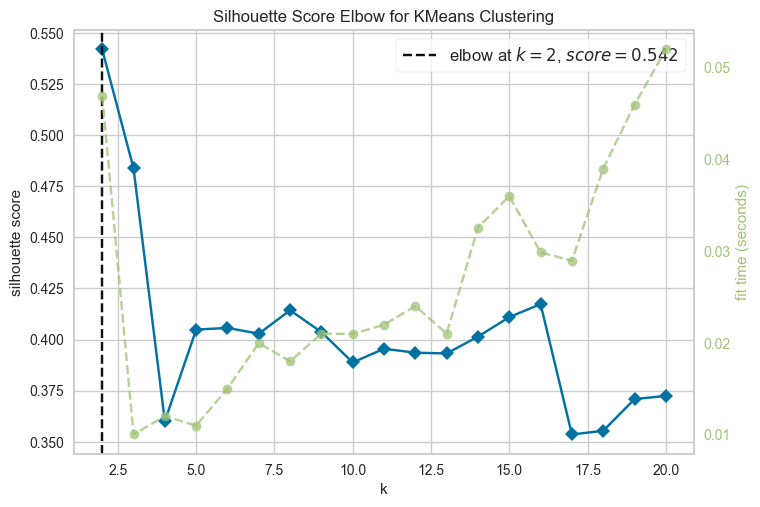

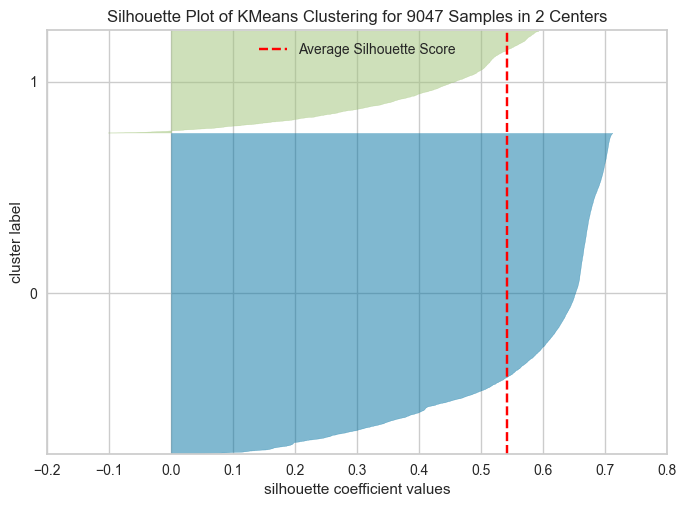

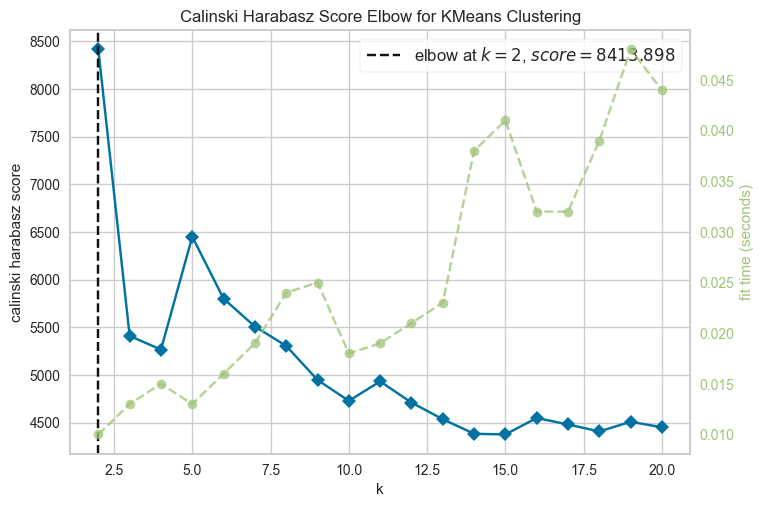

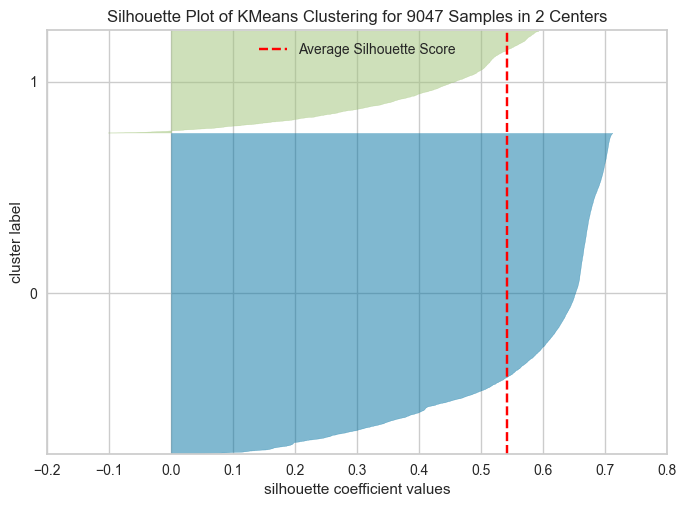

************************************************************************************************
**************************************** Min Max Scaler ****************************************
************************************************************************************************


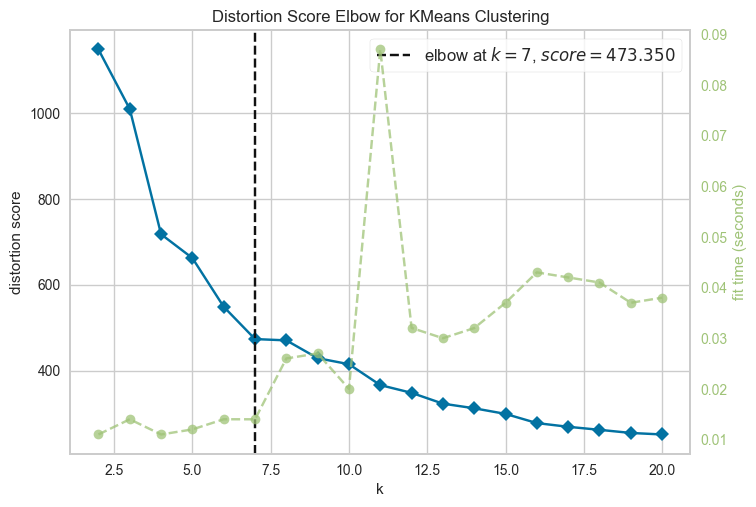

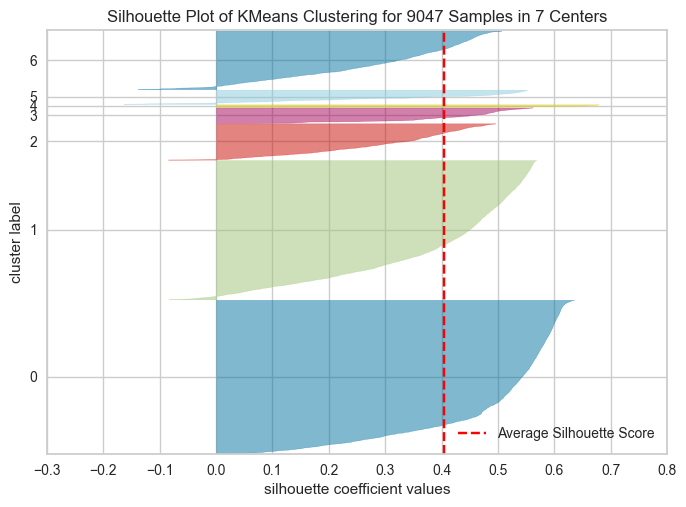

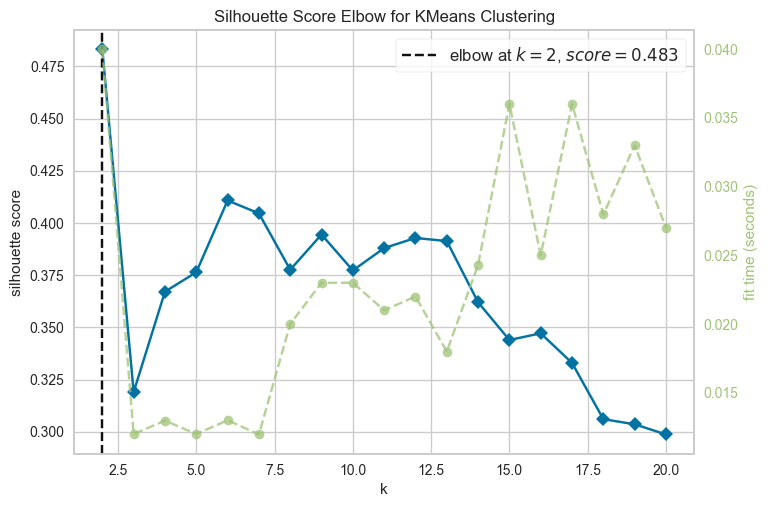

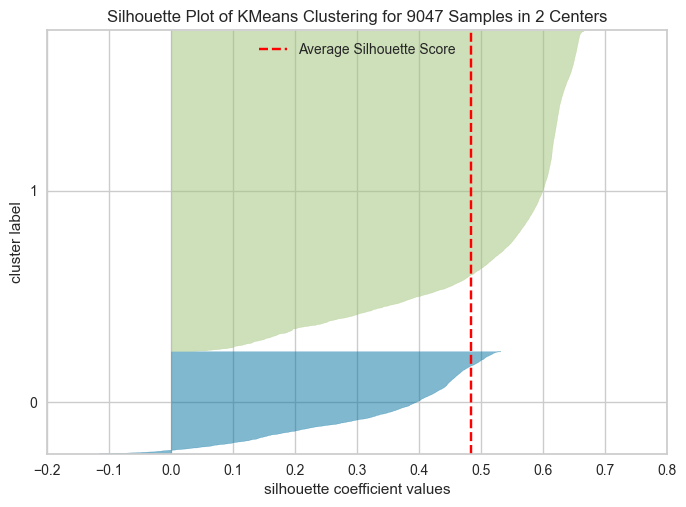

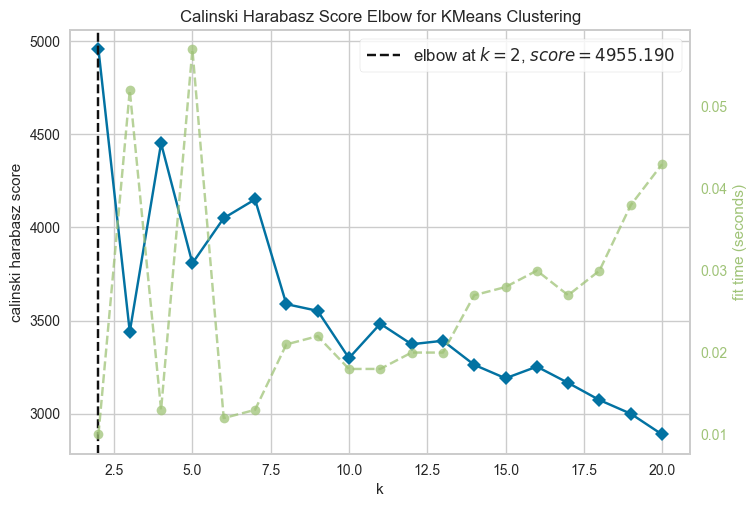

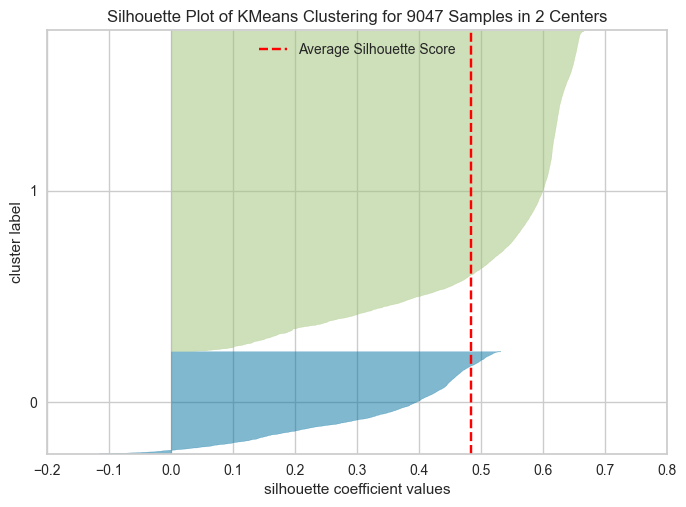

************************************************************************************************
*************************************** Standard Scaler ****************************************
************************************************************************************************


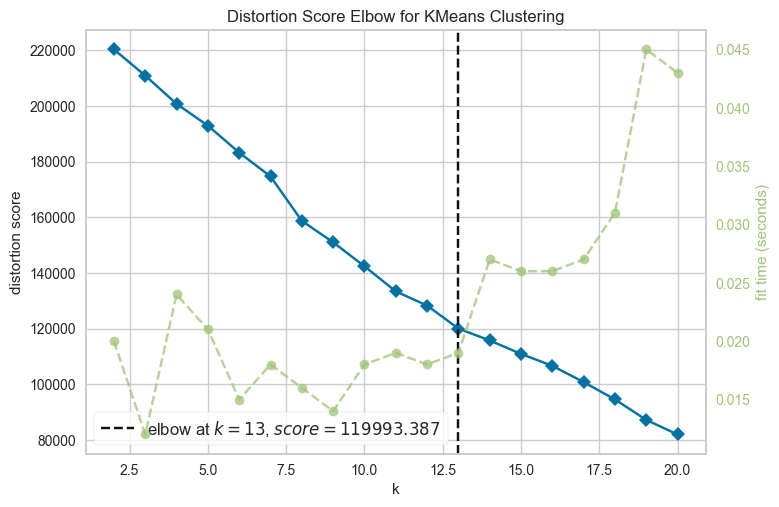

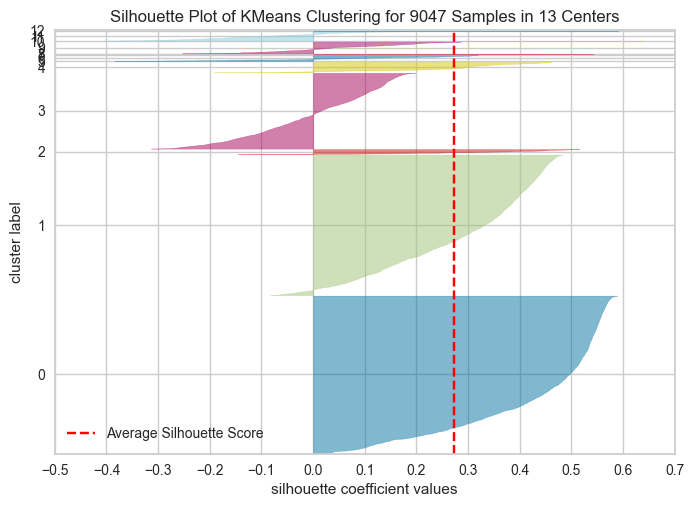

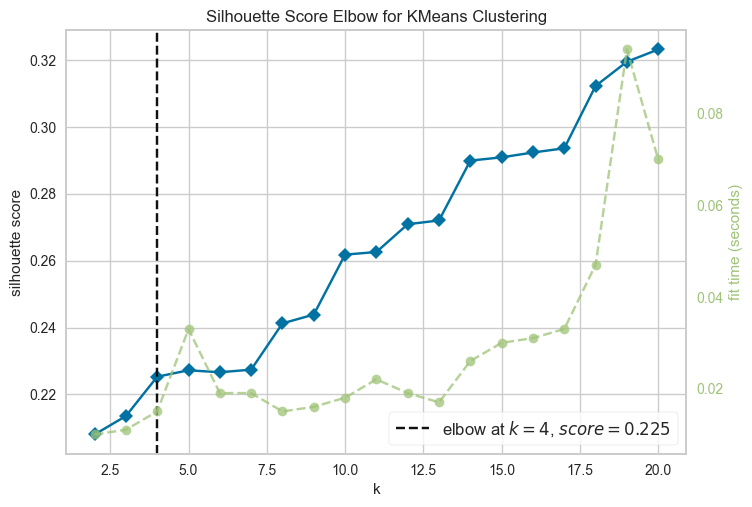

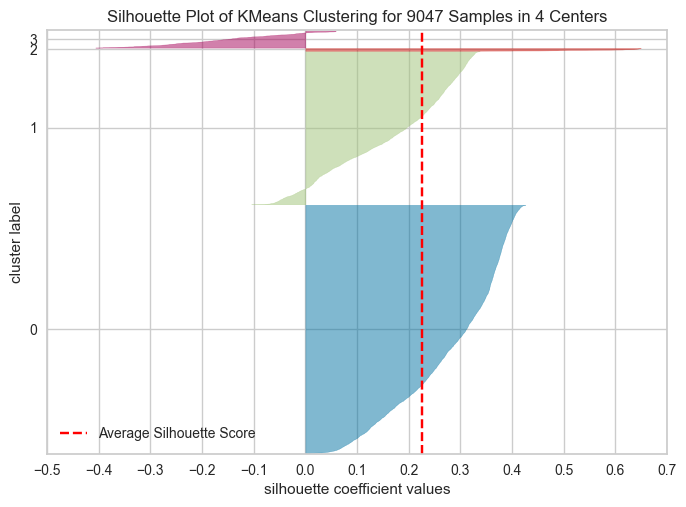

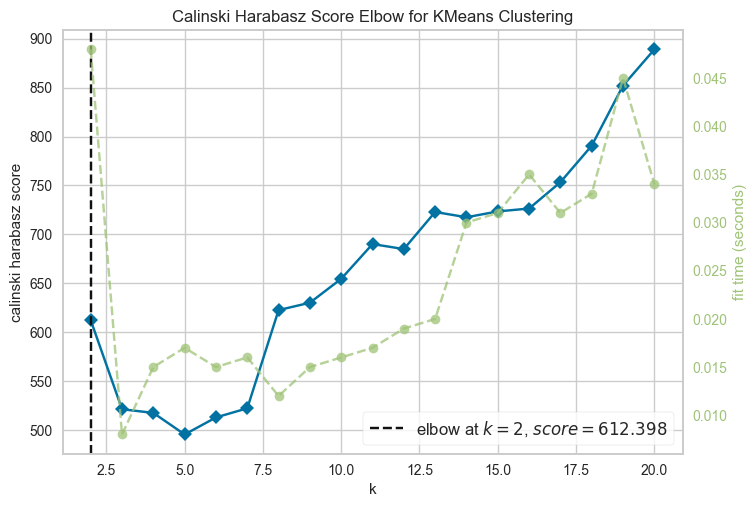

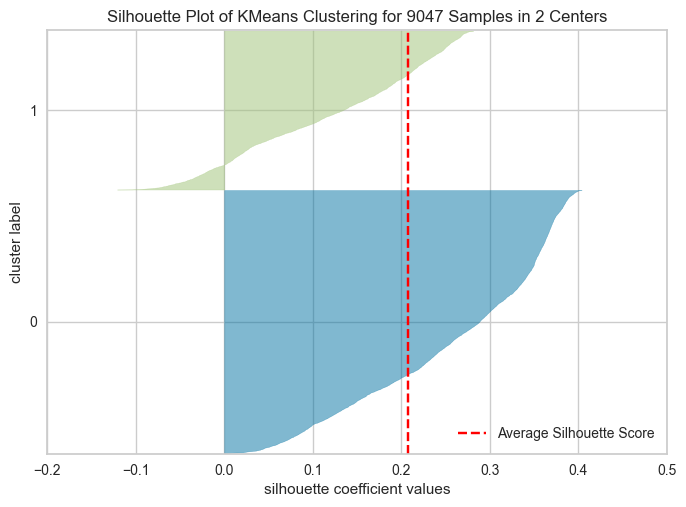

In [18]:
cluster_with_KMeans(ingredients)

## **AGGLOMERATIVE CLUSTERING**

In [19]:
def check_agglomerative_elbow(dataset):
    for scaler in [None, MinMaxScaler(), StandardScaler()]:
        print_scaler_header(scaler)

        if scaler is None:
            scaled_data = dataset
        else:
            scaled_data = scaler.fit_transform(dataset)

        for metric in ["distortion", "silhouette", "calinski_harabasz"]:
            print(96 * '-')

            elbow_visualizer = KElbowVisualizer(AgglomerativeClustering(), metric=metric, k=20)
            elbow_visualizer.fit(dataset)
            elbow_visualizer.show()

            labels = AgglomerativeClustering(n_clusters=elbow_visualizer.elbow_value_).fit_predict(scaled_data)
            show_silhouette_plot(labels, silhouette_samples(scaled_data, labels), silhouette_score(scaled_data, labels))

************************************************************************************************
****************************************** No Scaler *******************************************
************************************************************************************************
------------------------------------------------------------------------------------------------


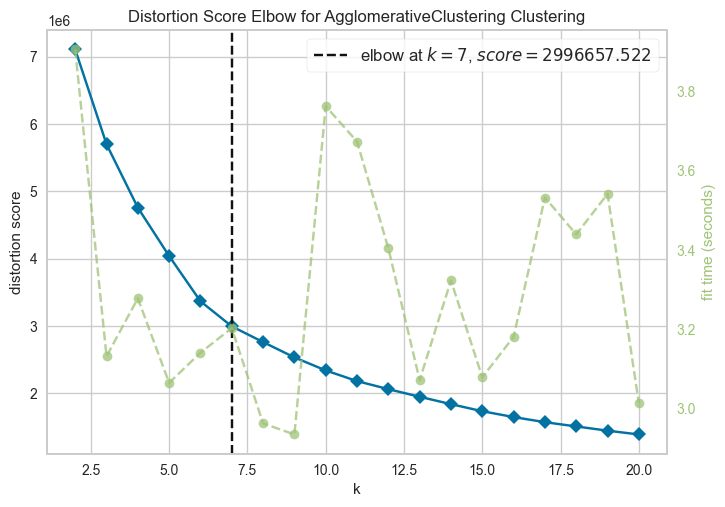

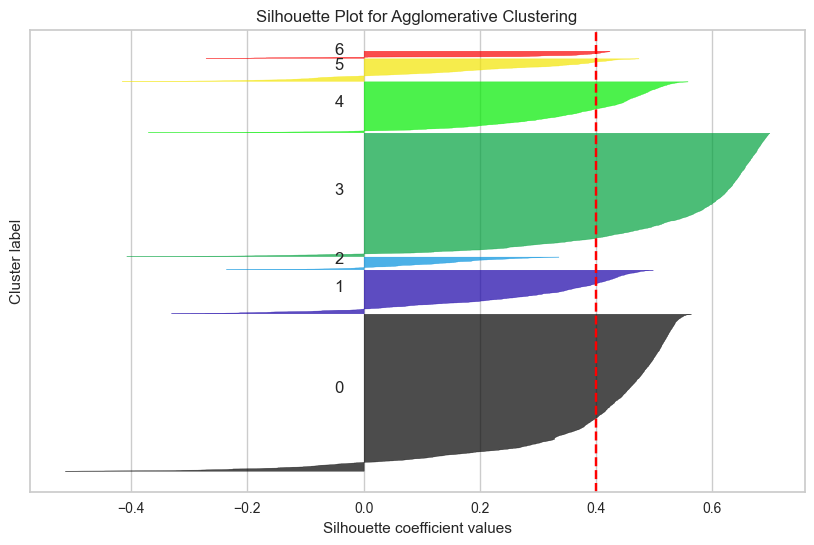

------------------------------------------------------------------------------------------------


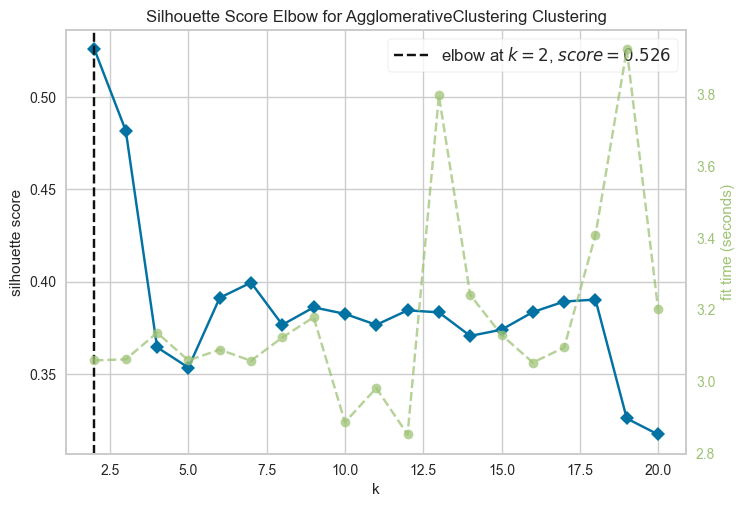

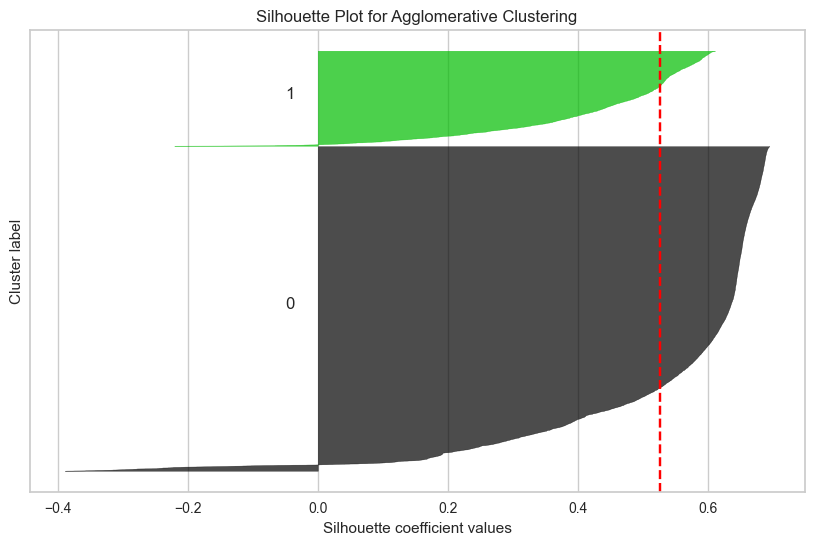

------------------------------------------------------------------------------------------------


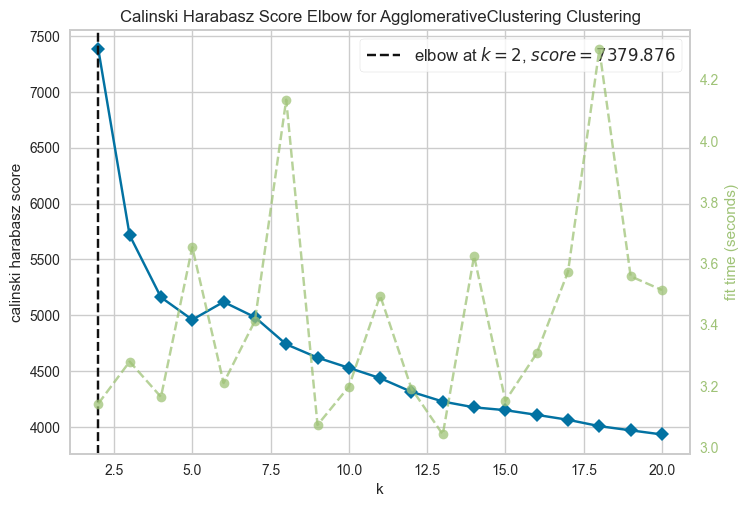

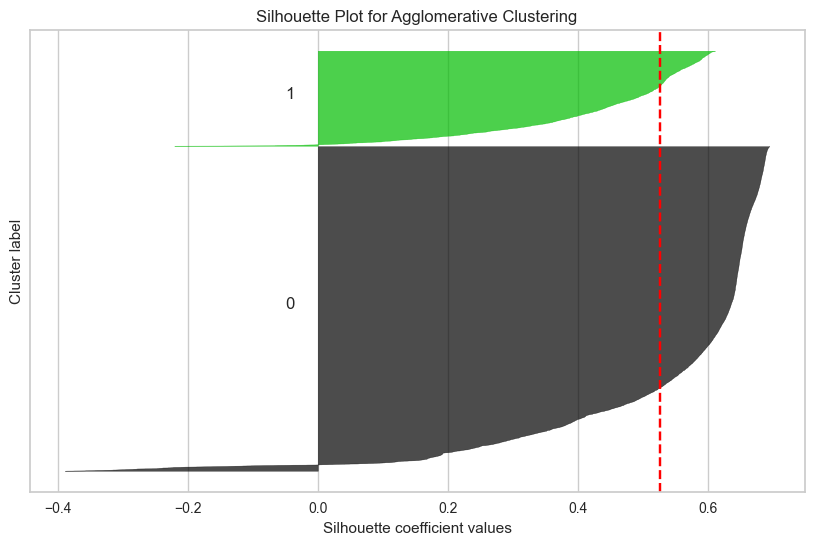

************************************************************************************************
**************************************** Min Max Scaler ****************************************
************************************************************************************************
------------------------------------------------------------------------------------------------


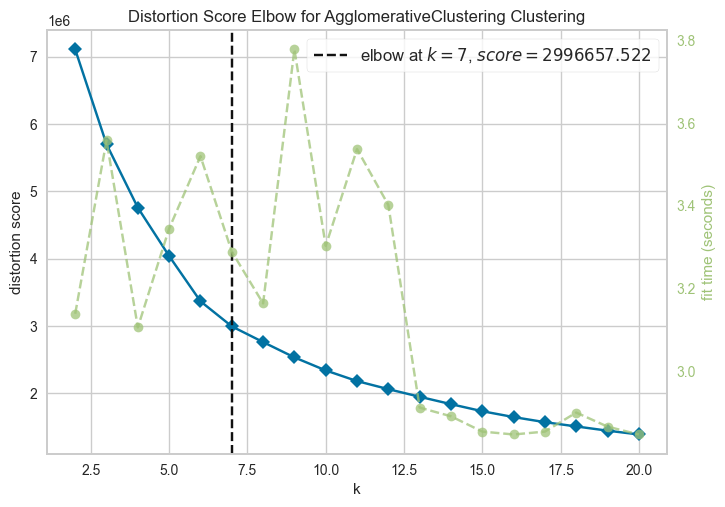

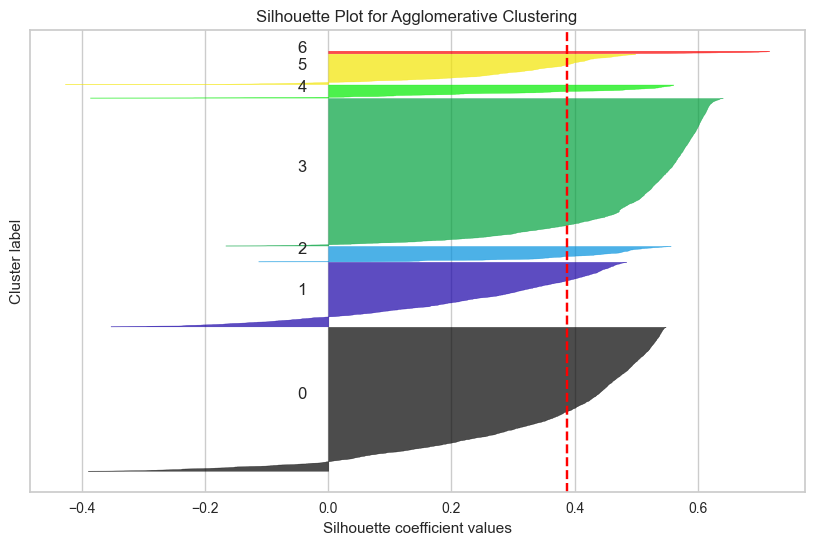

------------------------------------------------------------------------------------------------


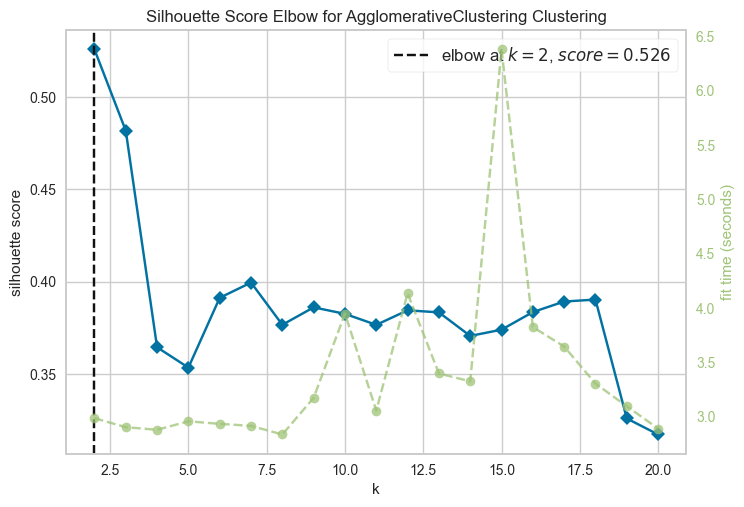

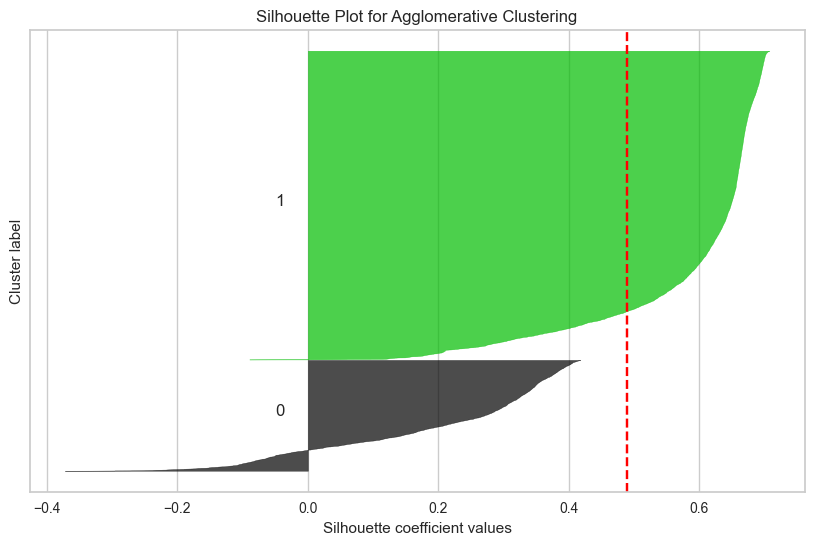

------------------------------------------------------------------------------------------------


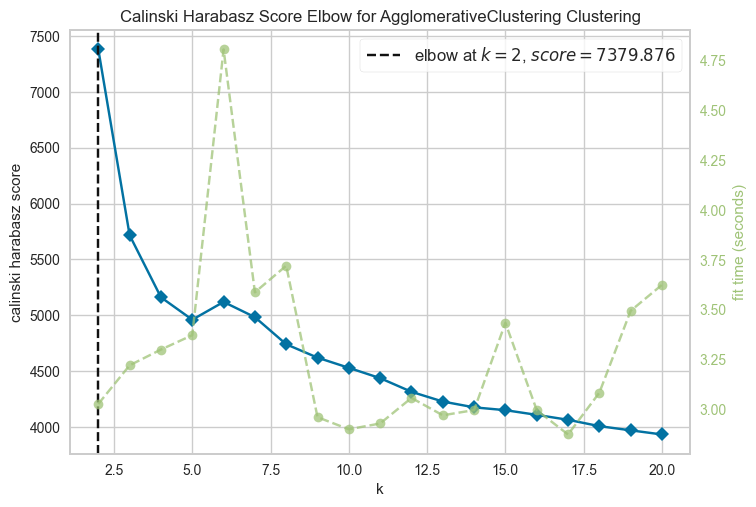

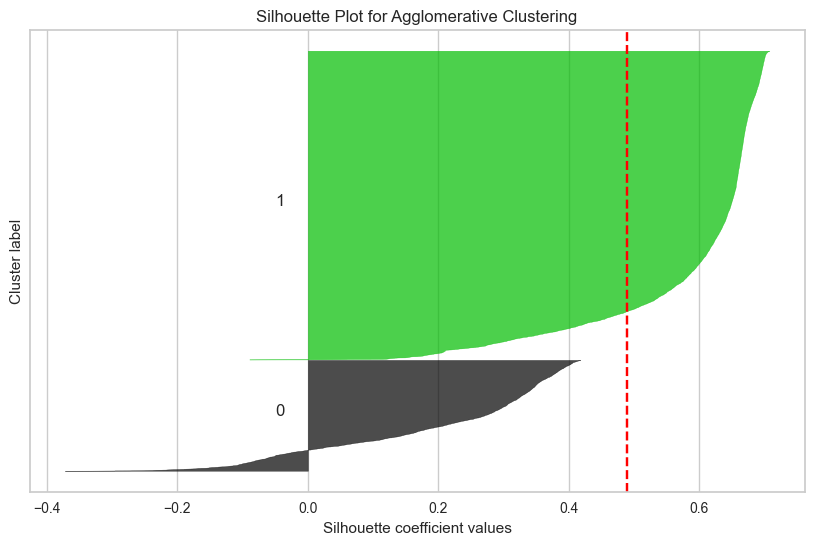

************************************************************************************************
*************************************** Standard Scaler ****************************************
************************************************************************************************
------------------------------------------------------------------------------------------------


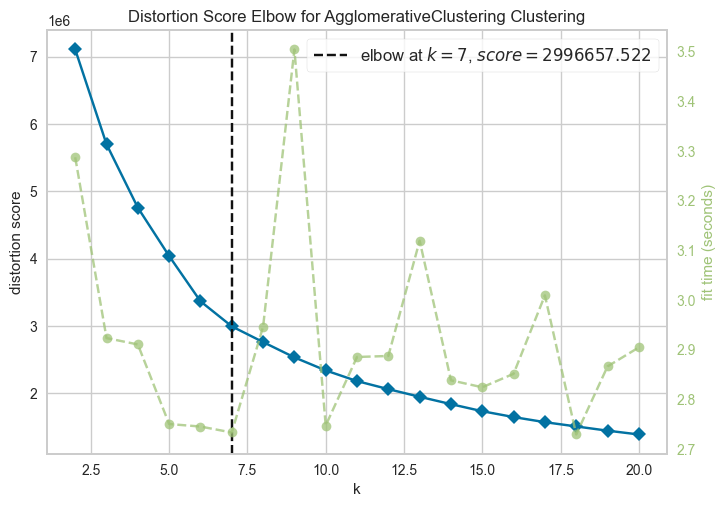

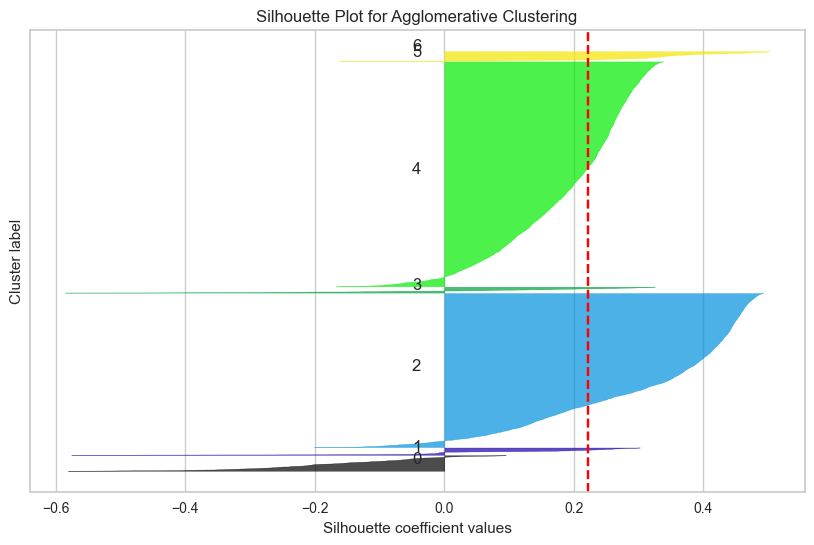

------------------------------------------------------------------------------------------------


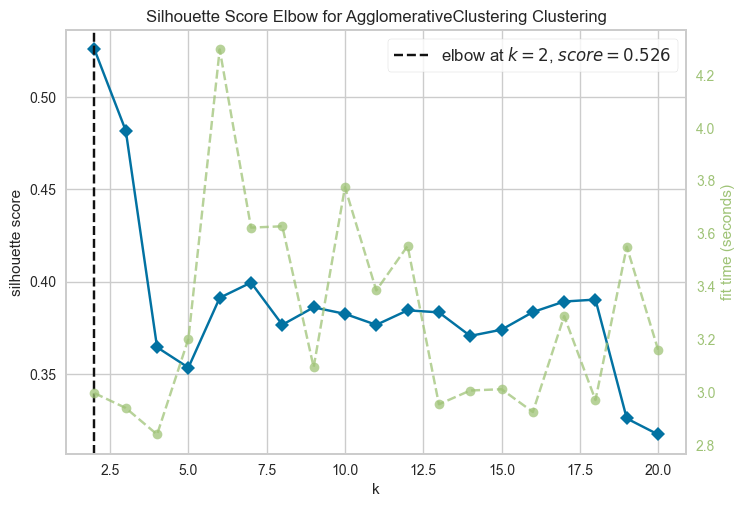

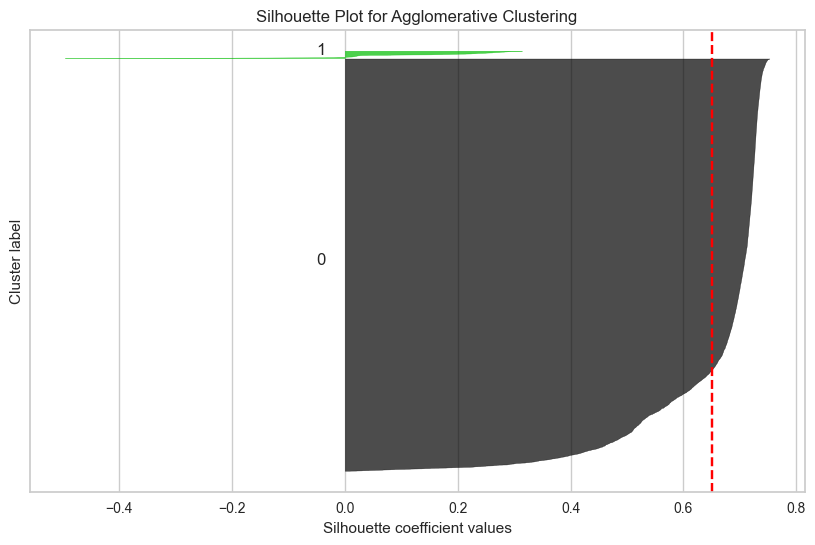

------------------------------------------------------------------------------------------------


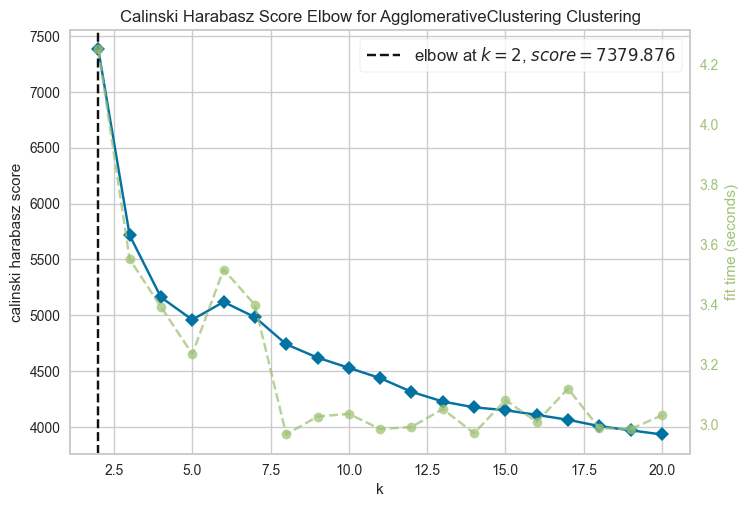

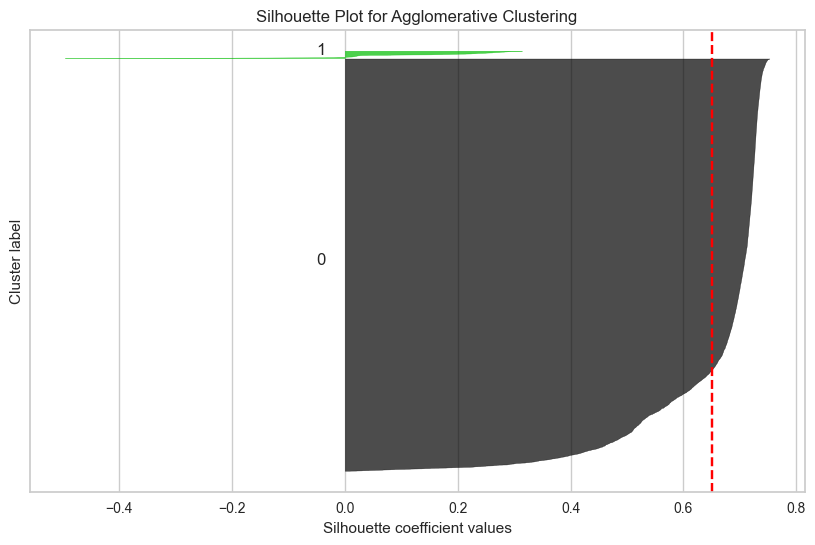

In [20]:
check_agglomerative_elbow(ingredients)

# **DBSCAN**

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), array([7911,  549,  188,   85,   27,  141,   37,   58,   24,   27]))
12.556648612799822%, cluster count with noise cluster: 10


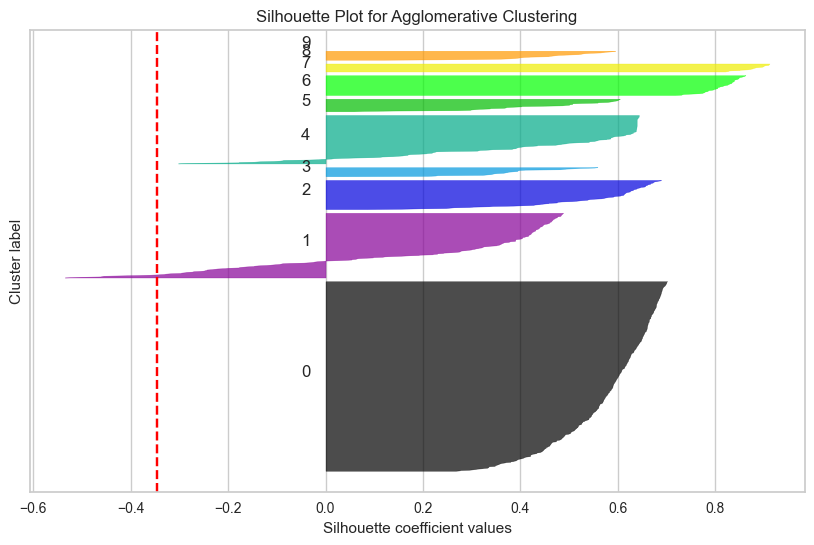

----------------------------------------------------------------------------------------------------
88.02918094395933%, cluster count with noise cluster: 6


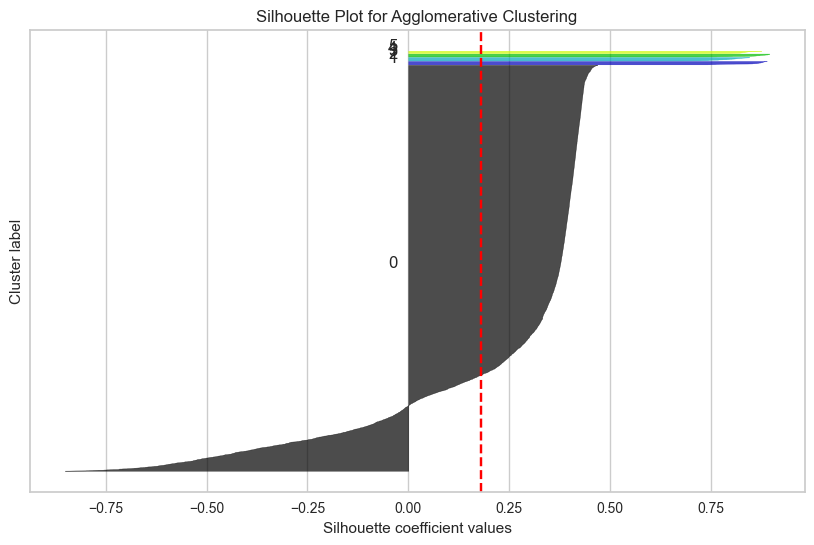

In [21]:
def eps_values():
    res = []
    max = 50.0
    start = 0.5
    step = 1.0
    while start <= max:
        res.append(start)
        start += step
    return res

def dbscan_grid_search():
    for min_samples in range(25, 60, 1):
        print(min_samples)
        for eps in eps_values():
            labels = DBSCAN(min_samples=min_samples, eps=eps).fit_predict(ingredients_minmax)
            coverage = get_dbscan_coverage(labels)
            values, counts = np.unique(labels, return_counts=True)
            if coverage > 90.0 and len(values) > 4 and np.max(counts) <= 4500:
                print(f"min_samples: {min_samples}, eps: {eps} coverage: {coverage}%, cluster count with noise cluster: {len(np.unique(labels))}");
                show_silhouette_plot(labels, silhouette_samples(ingredients_minmax, labels), silhouette_score(ingredients_minmax, labels))

labels = DBSCAN(min_samples=18, eps=0.8).fit_predict(ingredients)
print(np.unique(labels, return_counts=True))
coverage = get_dbscan_coverage(labels)
print(f"{coverage}%, cluster count with noise cluster: {len(np.unique(labels))}");
show_silhouette_plot(labels, silhouette_samples(ingredients, labels), silhouette_score(ingredients, labels))

print("-" * 100)

labels = DBSCAN(min_samples=40, eps=10.0).fit_predict(ingredients)
coverage = get_dbscan_coverage(labels)
print(f"{coverage}%, cluster count with noise cluster: {len(np.unique(labels))}");
show_silhouette_plot(labels, silhouette_samples(ingredients, labels), silhouette_score(ingredients, labels))

# **CLUSTER EVALUATION**

In [22]:
def plot_using_tsne(data, labels):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=50)
    plt.title("t-SNE Visualization of KMeans Clustering")
    plt.xlabel("t-SNE Feature 1")
    plt.ylabel("t-SNE Feature 2")
    plt.colorbar(label='Cluster')
    plt.show()


def plot_cluster_distributions(data, labels):
    labeled_data = data.copy()
    labeled_data['cluster'] = labels
    features = data.columns
    n_features = len(features)

    fig, axes = plt.subplots(n_features, 1, figsize=(10, 4 * n_features), sharex=False)

    for i, feature in enumerate(features):
        ax = axes[i] if n_features > 1 else axes
        for cluster in sorted(labeled_data['cluster'].unique()):
            sns.kdeplot(data=labeled_data[labeled_data['cluster'] == cluster], x=feature, ax=ax, label=f'Cluster {cluster}')
        ax.set_title(f'Density Plot of {feature} by Cluster')
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_3d_graph(data, labels):
    tsne = TSNE(n_components=3, random_state=42)
    data_3d = tsne.fit_transform(data)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2],
                        c=labels, cmap='viridis', s=50, alpha=0.7)

    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    ax.set_title("3D t-SNE Cluster Visualization")
    ax.set_xlabel("TSNE 1")
    ax.set_ylabel("TSNE 2")
    ax.set_zlabel("TSNE 3")
    plt.show()


def plot_interactive_3d_clusters(data, labels):
    tsne = TSNE(n_components=3, random_state=42)
    data_3d = tsne.fit_transform(data)

    df = pd.DataFrame(data_3d, columns=['TSNE1', 'TSNE2', 'TSNE3'])
    df['Cluster'] = labels.astype(str)

    fig = px.scatter_3d(df, x='TSNE1', y='TSNE2', z='TSNE3',
                        color='Cluster', opacity=0.7,
                        title="Interactive 3D t-SNE Cluster Plot")

    fig.show()


def plot_spider_graph(data, labels, ids):
    df_scaled = data.copy()
    df_scaled['Cluster'] = labels
    cluster_means = df_scaled.groupby('Cluster').mean()

    categories = list(cluster_means.columns)

    names = ids.drop(columns=['NDB_No'])
    names['Cluster'] = labels
    grouped_names = names.groupby('Cluster')

    for i in range(cluster_means.shape[0]):
        fig = go.Figure()

        fig.add_trace(go.Scatterpolar(
            r=cluster_means.iloc[i].values,
            theta=categories,
            fill='toself',
            name=f'Cluster {i}'
        ))

        fig.update_layout(
            polar=dict(radialaxis=dict(visible=True)),
            showlegend=False,
            title=f"Radar Chart - Cluster {i}"
        )

        fig.show()

        group = grouped_names.get_group(i)
        print(f"\nCluster {i}: ({len(group)} examples.)")
        samples = group.sample(n=min(20, len(group)), random_state=42)
        for example in samples['Descrip'].to_list():
            print(example)


def plot_cluster_graphs(data, labels, ids):
    plot_using_tsne(data, labels)
    #plot_interactive_3d_clusters(data, labels)
    plot_spider_graph(data, labels, ids)
    #plot_cluster_distributions(data, labels)


## **KMEANS CLUSTER EVALUATION**

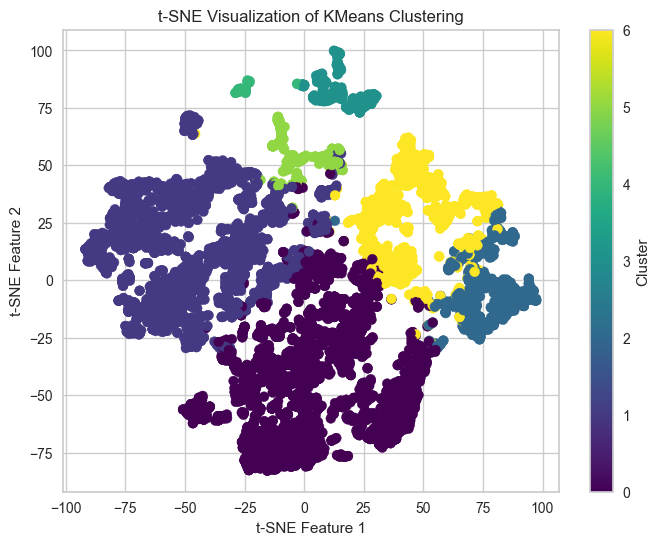


Cluster 0: (3308 examples.)
winged bns mature seeds ckd bld wo salt
lentils sprouted ckd stir-fried wsalt
peasonions frz ckd bld drnd wosalt
tangerine juice raw
noodles japanese soba ckd
pasta ckd unenr w added salt
soup chick w rice cnd cond
babyfood dinner bf noodle jr
seaweed wakame raw
soup chunky bf cnd rts
pickle relish hot dog
artichokes (globe or french) raw
salad drsng honey mustard drsng red cal
rice white medium-grain enr ckd
peppers swt grn ckd bld drnd wosalt
peas edible-podded frz ckd bld drnd wosalt
salad drsng french drsng red fat
beverages ocean spray cran pomegranate
potatoes russet flesh  skn bkd
melons honeydew raw



Cluster 1: (3001 examples.)
steelhead trout dried flesh (shoshone bannock)
crab alaska king raw
ground turkey 93 ln 7 fat raw
moose liver brsd (alaska native)
chicken roasting dk meat meat only raw
lamb australian imp frsh leg bttm bnless ln 18" fat raw
beef chuck shrt ribs bnless ln  fat 0" fat sel raw
cheese sprd past process american
pork frsh var meatsby-products ears frz ckd simmrd
beef loin top loin stk bnls lip off ln 0" fat all grds raw
lamb var meatsby-products spleen ckd brsd
beef chk eye cntry-style ribs bnl ln  fat 0" fat all gr raw
lamb var meatsby-products spleen raw
beef top sirloin steak ln  fat 0" fat choic ckd brld
veal comp of rtl cuts ln ckd
smelt dried (alaska native)
beef rib back ribs bone-in ln  fat 0" fat choic ckd brsd
ostrich oyster raw
ground turkey fat free patties brld
meatballs meatless



Cluster 2: (782 examples.)
keebler chips deluxe soft 'n chewy choc chip cookies
candies mars snack us pop'ables 3 musketeers bite size
archway home style cookies  old fashioned molasses
babyfood snack gerber graduate fruit strips real fruit bars
candies tamarind
candies mars snackfood us cocoavia choc covered almonds
keebler vanilla wafers minis rainbow
cake snack cakes creme-filled sponge
puddings banana dry mix reg
kellogg's pop-tarts yum-azing vanilla milkshake toaster past
jams and preserves
candies mars snack us starburst fruit chews frtcrem
nuts cocnt crm cnd swtnd
candies nestle raisinets choc covered raisins
cereals rte quaker nat granola appl cranberry almond
cereals rte post cocoa pebbles
kellogg's pop-tarts frstd sugar cookie toaster pastries
inf formula  mead johnson next step prosobee pdr not recon
keebler waffle bowls
keebler fudge shoppe magic middles fudge filled cookies pnut



Cluster 3: (332 examples.)
asparagus ckd bld drnd wsalt
oil industrial soy (parthydr ) palm  icings  fillings
moon fish
veg oil sprd 60 fat sticktubbottle wo salt wvit d
beverages v8 splash juc drinks mango peach
bacon bits meatless
inf formula mead johnson enfamil w iron pdr
celery seed
maagaa
octopus common raw
bev h2o w added vit  min bottles swtnd ast fruit flavors
carrots ckd bld drnd wsalt
snacks soy chips or crisps salted
cookies gluten-free lemon wafer
peppers swt red frz chopd bld drnd wo salt
inf formula mead johnson  pregestimil  wiron  pdr no recon
mustard greens raw
cake snk cakes not choc w icing or filling l-f w add fiber
spices mustard sd ground
candies mars snack us cocoavia blueberry  almond choc bar



Cluster 4: (58 examples.)
pomegranate  maroon seeds 
goat  spleen
mango  ripe  himsagar 
sweet potato  pink skin 
chillies  green-3 
rice  raw  milled 
shelavu
garlic  big clove 
sheep  brain
red snapper  small 
pangas
queen fish
grapes  seeded  round  red 
celery stalk
milk  whole  buffalo
apple  big 
apricot  dried 
brinjal-10
brinjal-21
tarlava



Cluster 5: (306 examples.)
oil sunflower linoleic (partially hydrogenated)
peanuts virginia oil-roasted wsalt
beef nz imp brisket navel end ln  fat ckd brsd
oil industrial palm kernel (hydrogenated) confection fat
walnuts english
veal external fat only raw
peanut butter chunky vitaminmineral fort
margarine-like margarine-butter blend soybn oil  butter
margarine-like veg oil-butter sprd tub w salt
oil industrial cocnt (hydrogenated) for toppings  whiteners
sunflower sd krnls oil rstd wosalt
sesame seeds whl rstdtstd
oil beluga whale (alaska native)
turkey young hen skn only ckd rstd
brazilnuts dried unblanched
oil apricot kernel
formulated wheat-based all flavors xcpt macadamia wosalt
margarine reg 80 fat comp tub w salt
peanuts spanish raw
almonds



Cluster 6: (1260 examples.)
pastry pastelitos de guava (guava pastries)
snacks mm mars combos snacks cheddar chs pretzel
austin chocolatey pnut butter crackers sandwich-type
cornmeal degermed enr white
corn flr yel masa enr
syrups table blends corn refiner sugar
cake yel lt dry mix
rye flour light
pie pecan prep from recipe
breadfruit seeds roasted
crackers whole-wheat
cereals rte kellogg kellogg's product 19
beef rnd top rnd ln 18" fat choic ckd pan-fried
pasta dry unenr
cereals crm of wheat 1 minute cook time dry
bagels pln unenr wca prop (incl onion poppy sesame)
kashi tlc fire rstd veg crackers
wheat flour whole-grain
cereals rte sun country kretschmer tstd wheat bran
beans yel mature seeds raw


In [23]:
k_means_labels = KMeans(n_clusters=7, random_state=42).fit_predict(ingredients_minmax)
plot_cluster_graphs(ingredients_minmax, k_means_labels, ingredients_names)

## **AGGLOMERATIVE CLUSTERING EVALUATION**

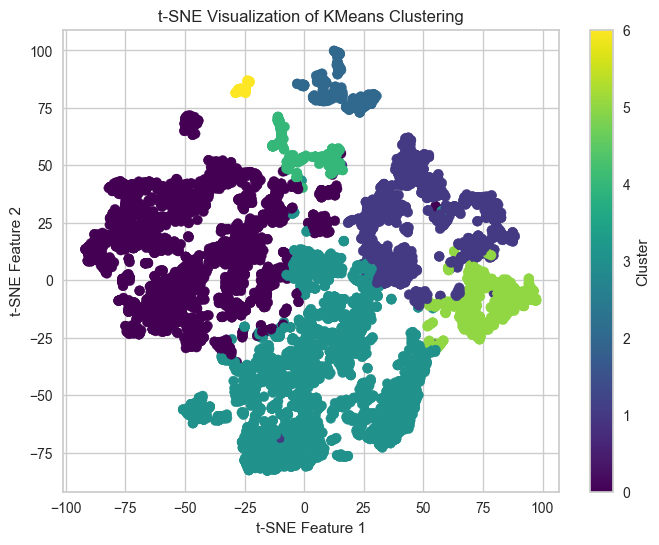


Cluster 0: (3120 examples.)
beef var meatsby-products tripe raw
beef var meatsby-products spleen raw
cheese mozzarella lo moist part-skim
pork frsh shldr arm picnic ln ckd rstd
pork loin leg cap steak bnless ln  fat ckd brld
cheese cream low fat
veal sirloin ln raw
chicken broilers or fryers dk meat thigh meat only raw
beef chuck clod steak ln only to 14" fat all grds ckd brsd
kfc fried chick original recipe thigh meat  skn w breading
tofu firm prep wca sulfatemagnesium chloride (nigari)
beef nz imp bolar blade ln  fat raw
lamb aus imp frsh foreshank lnfat 18"fat raw
beef top sirloin steak ln  fat 18" fat all grds ckd brld
beef brisket flat half ln  fat 18" fat choic raw
chicken broilers or fryers meatskn ckd stwd
beef chuck mock tender steak bnless ln 0" fat all grds raw
vitasoy usa organic nasoya ex firm tofu
beef comp of rtl cuts ln 18" fat sel raw
cod atlantic driedsalted



Cluster 1: (1399 examples.)
ice crm sndwch
cereals rte general mills basic 4
bread crumbs dry grated seasoned
cereals quaker corn grits inst cheddar chs flavor dry
mary's gone crackers original crackers organic gluten free
frostings white fluffy dry mix prep wh2o
cereals rte health valley fiber 7 flakes
cereals rte ralston corn biscuits
crackers multigrain
chili powder
bread whole-wheat prep from recipe tstd
formul bar ma snackfo us snicke marath ener bar all flavo
cereals rte cascadian farm honey nut o's
cereals rte quaker oatmeal squares cinn
cereals rte kashi indigo morning
maize  dry 
wheat  vermicelli  roasted 
snacks potato chips lightly salted
cereals rte quaker mother's pnut butter bumpers crl
anise seed



Cluster 2: (334 examples.)
asparagus ckd bld drnd wsalt
cereals rte granola homemade
moon fish
fast foods chick breaded  fried bnless pieces pln
beverages v8 splash juc drinks mango peach
pie blueberry commly prep
inf formula mead johnson enfamil w iron pdr
celery seed
cereals rte kashi 7 whl grain puffs
margarine-like veg oil sprd 60 fat tub w salt
bev h2o w added vit  min bottles swtnd ast fruit flavors
carrots ckd bld drnd wsalt
snacks soy chips or crisps salted
mackerel jack cnd drnd sol
beverages v8 splash juc drinks orchard blend
potato chips pln unsalted
inf formula  mead johnson  enfamil  prm  newborn  pwd
candies milk choc coatd pnuts
spices mustard sd ground
candies rolo caramels in milk choc



Cluster 3: (3197 examples.)
papaya nectar canned
soup clam chowder new england cnd prep w eq volume h2o
orange peel raw
taro tahitian ckd wosalt
cowpeas (blackeyes) immat seeds frz ckd bld drnd w salt
apricots cnd hvy syrup pk wskn solliquids
silk coffee soymilk
soup onion cnd cond
peppers hot chili red raw
restaurant family style spaghetti  meatballs
campbell's homestyle mexican style chick tortilla soup
beans pinto mature seeds ckd bld wosalt
beverages nestle boost plus nutritional drk rtd
campbell's spaghettios spaghetti in tomato  chs sau
soup chick mushroom chowder chunky rts single brand
babyfood dssrt custard pudd vanilla str
chokecherries raw pitted (shoshone bannock)
soup progresso bf barley traditional ready to serve
beverages pnappl  grapefruit juc drk cnd
pace red taco sau



Cluster 4: (284 examples.)
veal external fat only raw
butter lt stk wsalt
shortening spl purpose for baking soybn (hydr) palmcttnsd
sesame butter tahini from unroasted krnls
beef australian imp wagyu seam fat aust marble score 9 raw
margarine-like butter-margarine blend 80 fat stk wo salt
meat drippings (lard bf tallow mutton tallow)
salad drsng ranch drsng reg
pork frsh fat raw
butter lt stk wosalt
veal comp of rtl cuts fat raw
fish oil sardine
salad drsng french home recipe
peanuts valencia oil-roasted wsalt
sunflower sd krnls oil rstd wosalt
sesame sd krnls dried (decort)
shortening confectionery cocnt (hydr)or palm kernel (hydr)
nuts almonds oil rstd w salt added smoke flavor
fish oil herring
salad drsng caesar drsng reg



Cluster 5: (657 examples.)
candies mars snackfood us snickers almond bar
keebler gingerbread men cookies holiday
keebler cinn toast grahams
toaster pastries kellogg kellogg's pop tarts frstd choc fudg
candies mars snackfood us mars almond bar
murray cookie jar classics butter cookies
keebler el fudge butter flav cookies
mother's vanilla sndwch cookies
goji berries dried
cereals rte kellogg's krave double choc crl
inf form abbott alimentum advance iron pdr notrec dhaara
candies hershey's golden almond solitaires
candies mars snackfood us pop snickers bite size candies
chocolate-flavored hazelnut sprd
keebler sandies simply shortbread cookies
keebler 100 cal right bites white fudge dipped pretzels
archway home style cookies  chocolate chip ice box
candies milk choc walmonds
girl scouts thin mints cookies
candies swt choc coatd fondant



Cluster 6: (56 examples.)
pomegranate  maroon seeds 
goat  spleen
mango  ripe  himsagar 
sweet potato  pink skin 
tarlava
rice  raw  milled 
shelavu
radish  elongate  white skin 
lime  sweet pulp 
red snapper  small 
orange  pulp 
queen fish
cho-cho-marrow
celery stalk
milk  whole  buffalo
apple  big 
apricot  dried 
brinjal-10
beef  spleen
yam  ordinary 


In [24]:
agglomerative_labels = AgglomerativeClustering(n_clusters=7).fit_predict(ingredients_minmax)
plot_cluster_graphs(ingredients_minmax, agglomerative_labels, ingredients_names)